In [1]:
from bertopic import BERTopic
import numpy as np
import pandas as pd
from transformers import pipeline
from bertopic.representation import TextGeneration
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import datetime
import nltk
from nltk.corpus import stopwords
import logging
import os
from dotenv import load_dotenv
from umap import UMAP
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
import openai
import spacy
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
from sklearn.metrics import silhouette_score
import os
from datetime import datetime
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator

load_dotenv()
OPENAI_KEY = os.getenv("OPENAI_KEY")

# Auxiliary Functions

In [2]:
def auto_save_figure(fig, figure_name, save_formats=['png'], 
                    width=1000, height=700, scale=2, output_dir="../../outputs/plots"):
    """
    Automatically save any Plotly or Matplotlib figure to disk with multiple formats and timestamp
    
    Parameters:
    -----------
    fig : plotly.graph_objects.Figure or matplotlib.figure.Figure
        The figure to save (supports both Plotly and Matplotlib)
    figure_name : str
        Descriptive name for the figure (will be used in filename)
    save_formats : list
        List of formats to save ['png', 'html', 'pdf', 'svg', 'jpeg']
    width : int
        Width of the saved image
    height : int
        Height of the saved image
    scale : int
        Scale factor for image resolution (higher = better quality)
    output_dir : str
        Directory to save the figures
    
    Returns:
    --------
    dict : Dictionary with saved file paths
    """
    if fig is None:
        print(f"❌ No figure provided for '{figure_name}'")
        return {}
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Generate timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    saved_files = {}
    
    # Detect figure type
    is_plotly = hasattr(fig, 'write_image') and hasattr(fig, 'write_html')
    is_matplotlib = hasattr(fig, 'savefig')
    
    if not is_plotly and not is_matplotlib:
        print(f"❌ Unsupported figure type for '{figure_name}': {type(fig)}")
        return {}
    
    for format_type in save_formats:
        # Clean figure name for filename (remove spaces, special chars)
        clean_name = "".join(c for c in figure_name if c.isalnum() or c in (' ', '-', '_')).rstrip()
        clean_name = clean_name.replace(' ', '_').lower()
        
        filename = f"{timestamp}_{clean_name}.{format_type}"
        filepath = os.path.join(output_dir, filename)
        
        try:
            if is_plotly:
                # Handle Plotly figures
                if format_type == 'html':
                    fig.write_html(filepath)
                    print(f"📊 Saved {figure_name} as HTML: {filename}")
                elif format_type in ['png', 'pdf', 'svg', 'jpeg']:
                    fig.write_image(
                        filepath,
                        width=width,
                        height=height,
                        scale=scale,
                        format=format_type
                    )
                    print(f"🖼️  Saved {figure_name} as {format_type.upper()}: {filename}")
                    
            elif is_matplotlib:
                # Handle Matplotlib figures
                if format_type == 'html':
                    # Convert matplotlib to HTML via mpld3 (if available) or skip
                    try:
                        import mpld3
                        html_str = mpld3.fig_to_html(fig)
                        with open(filepath, 'w') as f:
                            f.write(html_str)
                        print(f"📊 Saved {figure_name} as HTML: {filename}")
                    except ImportError:
                        print(f"⚠️  Skipping HTML for matplotlib figure '{figure_name}' (mpld3 not available)")
                        continue
                elif format_type in ['png', 'pdf', 'svg', 'jpeg']:
                    # Set DPI based on scale
                    dpi = 100 * scale
                    fig.savefig(
                        filepath,
                        format=format_type,
                        dpi=dpi,
                        bbox_inches='tight',
                        facecolor='white',
                        edgecolor='none'
                    )
                    print(f"🖼️  Saved {figure_name} as {format_type.upper()}: {filename}")
            
            saved_files[format_type] = os.path.abspath(filepath)
            
        except Exception as e:
            print(f"❌ Error saving {figure_name} as {format_type}: {e}")
    
    if saved_files:
        print(f"✅ Total saved: {len(saved_files)} file(s) for '{figure_name}'")
        print(f"📁 Location: {os.path.abspath(output_dir)}")
        print("-" * 60)
    
    return saved_files

In [3]:
def enhance_bertopic_figure(fig, viz_type):
    """
    Enhance BERTopic figures with specific optimizations for each visualization type
    
    Parameters:
    -----------
    fig : plotly.graph_objects.Figure
        The BERTopic figure to enhance
    viz_type : str
        Type of visualization ('topics', 'topics_per_class', 'heatmap', etc.)
    
    Returns:
    --------
    plotly.graph_objects.Figure : Enhanced figure
    """
    if fig is None:
        return fig
        
    try:
        if viz_type == 'topics':
            # Fix intertopic distance map cropping issues
            fig.update_layout(
                # Increase margins to prevent cropping
                margin=dict(l=80, r=80, t=100, b=80),
                # Ensure proper aspect ratio
                width=1200,
                height=900,
                # Add padding to prevent cluster cutoff
                xaxis=dict(
                    range=None,  # Let plotly auto-scale
                    automargin=True,
                    showgrid=True,
                    gridcolor='rgba(0,0,0,0.1)'
                ),
                yaxis=dict(
                    range=None,  # Let plotly auto-scale  
                    automargin=True,
                    showgrid=True,
                    gridcolor='rgba(0,0,0,0.1)'
                ),
                # Improve title positioning
                title=dict(
                    x=0.5,
                    xanchor='center',
                    y=0.95,
                    font=dict(size=16)
                )
            )
            
        elif viz_type == 'topics_per_class':
            # Ensure all topics are visible (not just the first one)
            # Make all traces visible by default
            if hasattr(fig, 'data'):
                for trace in fig.data:
                    trace.visible = True
                    
            # Improve layout for topics per class
            fig.update_layout(
                margin=dict(l=60, r=60, t=120, b=60),
                width=1200,
                height=800,
                # Ensure legend is visible and functional
                showlegend=True,
                legend=dict(
                    orientation="v",
                    yanchor="top",
                    y=1,
                    xanchor="left",
                    x=1.02,
                    bgcolor='rgba(255,255,255,0.8)',
                    bordercolor='rgba(0,0,0,0.3)',
                    borderwidth=1
                ),
                # Improve title
                title=dict(
                    x=0.5,
                    xanchor='center',
                    font=dict(size=16)
                )
            )
            
        elif viz_type == 'heatmap':
            # Optimize heatmap layout
            fig.update_layout(
                margin=dict(l=120, r=80, t=100, b=120),
                width=1000,
                height=700
            )
            
        elif viz_type == 'document_datamap':
            # Optimize document datamap
            fig.update_layout(
                margin=dict(l=80, r=80, t=100, b=80),
                width=1200,
                height=900
            )
            
        elif viz_type == 'hierarchy':
            # Optimize hierarchy plot
            fig.update_layout(
                margin=dict(l=100, r=100, t=100, b=100),
                width=1400,
                height=800
            )
            
    except Exception as e:
        print(f"⚠️  Warning: Could not enhance {viz_type} figure: {e}")
        
    return fig

In [4]:
def get_figure_dimensions(fig):
    """
    Safely extract width and height from a Plotly figure
    """
    try:
        # Try to access width and height from layout
        layout = fig.layout if hasattr(fig, 'layout') else None
        if layout:
            width = getattr(layout, 'width', None) or 1000
            height = getattr(layout, 'height', None) or 700
            return width, height
    except:
        pass
    
    # Fallback to defaults
    return 1000, 700

In [5]:
# Enhanced wrapper function for BERTopic visualizations with optimizations
def save_bertopic_figure_enhanced(fig, viz_type, group_name="Female_ADHD", apply_enhancements=True, **kwargs):
    """
    Enhanced function for saving BERTopic visualizations with automatic optimizations
    
    Parameters:
    -----------
    fig : plotly.graph_objects.Figure or matplotlib.figure.Figure
        The BERTopic figure to save
    viz_type : str
        Type of visualization ('topics', 'heatmap', 'hierarchy', 'topics_per_class', etc.)
    group_name : str
        Name of the group being analyzed
    apply_enhancements : bool
        Whether to apply BERTopic-specific enhancements (default: True)
    **kwargs : additional arguments passed to auto_save_figure
    """
    # Apply enhancements if requested and if it's a Plotly figure
    if apply_enhancements and hasattr(fig, 'update_layout'):
        print(f"🔧 Applying {viz_type} specific optimizations...")
        fig = enhance_bertopic_figure(fig, viz_type)
    
    figure_name = f"bertopic_{viz_type}_{group_name}"
    
    # Set default high-quality settings for BERTopic figures
    kwargs.setdefault('save_formats', ['png', 'html'])
    kwargs.setdefault('scale', 2)
    
    # Safely get figure dimensions
    width, height = get_figure_dimensions(fig)
    kwargs.setdefault('width', width)
    kwargs.setdefault('height', height)
    
    return auto_save_figure(fig, figure_name, **kwargs)

print("✅ Enhanced BERTopic auto-save functions loaded!")
print("🔧 New optimizations:")
print("   📊 Intertopic distance: Larger margins, better scaling")
print("   📈 Topics per class: All topics visible by default")  
print("   🎨 All figures: Improved layouts and positioning")
print("   💾 High-quality: Optimized settings for each viz type")
print("   🐛 Fixed: Layout dimension access error")
print("-" * 60)

✅ Enhanced BERTopic auto-save functions loaded!
🔧 New optimizations:
   📊 Intertopic distance: Larger margins, better scaling
   📈 Topics per class: All topics visible by default
   🎨 All figures: Improved layouts and positioning
   💾 High-quality: Optimized settings for each viz type
   🐛 Fixed: Layout dimension access error
------------------------------------------------------------


In [6]:
def translate_topic_words(topic_model, target_language='en', source_language='pt'):
    """
    Translate topic words from Portuguese to English
    """
    translator = GoogleTranslator(source=source_language, target=target_language)
    
    # Hardcoded translations for specific terms
    hardcoded_translations = {
        'phda': 'adhd',
        'PHDA': 'ADHD',
        'Phda': 'ADHD'
    }
    
    topics_dict = topic_model.get_topics()
    translated_topics = {}
    
    for topic_id, words_scores in topics_dict.items():
        if topic_id == -1:  # Skip noise topic
            continue
            
        # Extract just the words (first element of each tuple)
        words = [word for word, score in words_scores]
        
        # Translate words
        try:
            translated_words = []
            for word in words:
                # Check if we have a hardcoded translation first
                if word in hardcoded_translations:
                    translated = hardcoded_translations[word]
                else:
                    translated = translator.translate(word)
                translated_words.append(translated)
            
            # Keep the same scores but with translated words
            translated_topic = [(translated_words[i], score) for i, (word, score) in enumerate(words_scores)]
            translated_topics[topic_id] = translated_topic
            
        except Exception as e:
            print(f"Error translating topic {topic_id}: {e}")
            # Keep original if translation fails
            translated_topics[topic_id] = words_scores
    
    return translated_topics

In [7]:
def visualize_barchart_translated_fixed(topic_model, translated_topics, topics=None, top_k_topics=6, n_words=5, 
                                        custom_labels=True, title="<b>Topic Word Scores</b>", 
                                        width=800, height=600):
    """
    Create a bar chart visualization in the exact same style as BERTopic's visualize_barchart
    but with translated words - FIXED VERSION for proper label mapping
    """
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    # Get topic information and prepare data
    topic_info = topic_model.get_topic_info()
    
    # Select topics to show (excluding outliers/noise topic -1)
    if topics is None:
        # Get top k topics by size (excluding noise topic -1)
        selected_topics = topic_info[topic_info['Topic'] != -1].head(top_k_topics)['Topic'].tolist()
    else:
        # Filter out -1 from provided topics
        selected_topics = [t for t in topics if t != -1]
    
    # Filter selected_topics to only include those that exist in translated_topics
    available_topics = [topic_id for topic_id in selected_topics if topic_id in translated_topics]
    
    print(f"DEBUG: Available topics for plotting: {available_topics}")
    
    # Create subplot titles ONLY for the topics that will actually be plotted
    # The key fix: properly map topic IDs to their position in the topic_info dataframe
    subplot_titles = []
    for topic_id in available_topics:
        if custom_labels and hasattr(topic_model, 'custom_labels_') and topic_model.custom_labels_:
            # Find the topic in topic_info and get its custom label
            topic_row = topic_info[topic_info['Topic'] == topic_id]
            if not topic_row.empty and 'CustomName' in topic_row.columns:
                topic_label = topic_row.iloc[0]['CustomName']
            elif not topic_row.empty and 'Name' in topic_row.columns:
                topic_label = topic_row.iloc[0]['Name']
            else:
                # Fallback: try to get from custom_labels_ array using topic position
                # Find the position of this topic in the topic_info (excluding outliers)
                non_outlier_topics = topic_info[topic_info['Topic'] != -1]
                topic_position = None
                for idx, row in non_outlier_topics.iterrows():
                    if row['Topic'] == topic_id:
                        topic_position = list(non_outlier_topics.index).index(idx)
                        break
                
                if topic_position is not None and topic_position < len(topic_model.custom_labels_):
                    topic_label = topic_model.custom_labels_[topic_position]
                else:
                    topic_label = f"Topic {topic_id}"
        else:
            topic_label = f"Topic {topic_id}"
        
        print(f"DEBUG: Topic {topic_id} -> Label: {topic_label}")
        subplot_titles.append(topic_label)
    
    # Prepare subplot structure - one row per topic that will actually be plotted
    n_topics = len(available_topics)
    if n_topics == 0:
        print("No topics available for plotting")
        return None
        
    fig = make_subplots(
        rows=n_topics, 
        cols=1,
        shared_xaxes=False,
        vertical_spacing=0.08,
        subplot_titles=subplot_titles
    )
    
    # Color scheme similar to BERTopic
    colors = ["#D55E00", "#0072B2", "#CC79A7", "#E69F00", "#56B4E9", "#009E73", "#F0E442"]
    
    # Process each topic that will actually be plotted
    for i, topic_id in enumerate(available_topics):
        # Get translated words and scores
        words_scores = translated_topics[topic_id][:n_words]
        words = [word for word, score in words_scores]
        scores = [score for word, score in words_scores]
        
        # Reverse order for proper display (highest scores at top)
        words = words[::-1]
        scores = scores[::-1]
        
        # Create horizontal bar trace
        trace = go.Bar(
            y=words,
            x=scores,
            orientation='h',
            marker=dict(
                color=colors[i % len(colors)],
                line=dict(color='rgba(0,0,0,0.3)', width=0.5)
            ),
            text=[f"{score:.3f}" for score in scores],
            textposition='outside',
            textfont=dict(size=11),
            hovertemplate='<b>%{y}</b><br>Score: %{x:.3f}<extra></extra>',
            showlegend=False,
            name=f"Topic {topic_id}"
        )
        
        fig.add_trace(trace, row=i+1, col=1)
    
    # Update layout to match BERTopic style
    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,
            xanchor="center",
            font=dict(size=16, color="black")
        ),
        height=height,
        width=width,
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(color="black", size=11),
        margin=dict(l=10, r=10, t=60, b=10)
    )
    
    # Update axes for each subplot
    for i in range(n_topics):
        # X-axis
        fig.update_xaxes(
            showgrid=True,
            gridwidth=1,
            gridcolor='rgba(0,0,0,0.1)',
            zeroline=True,
            zerolinewidth=1,
            zerolinecolor='rgba(0,0,0,0.3)',
            showline=True,
            linewidth=1,
            linecolor='black',
            row=i+1, col=1
        )
        
        # Y-axis
        fig.update_yaxes(
            showgrid=False,
            showline=True,
            linewidth=1,
            linecolor='black',
            tickfont=dict(size=10),
            row=i+1, col=1
        )
    
    # Update annotation style for subplot titles
    fig.update_annotations(font_size=12, font_color="black")
    
    return fig

In [8]:
def get_silhouette_score(topic_model, embeddings):
    """
    Calculate silhouette score for topic clustering quality assessment
    
    Parameters:
    -----------
    topic_model : BERTopic
        The trained BERTopic model
    embeddings : np.array
        Original document embeddings used for training
        
    Returns:
    --------
    float : Silhouette score (-1 to 1, higher is better)
    """
    # Get document-topic assignments
    document_topics = topic_model.topics_
    
    # Validate inputs
    if len(embeddings) != len(document_topics):
        print(f"Warning: Embedding length ({len(embeddings)}) != topic assignments length ({len(document_topics)})")
        # Use the minimum length to avoid index errors
        min_len = min(len(embeddings), len(document_topics))
        embeddings = embeddings[:min_len]
        document_topics = document_topics[:min_len]
    
    # Filter out outlier/noise topics (-1)
    valid_indices = [i for i, topic in enumerate(document_topics) if topic != -1]
    
    # Check if we have enough valid documents and topics
    if len(valid_indices) < 2:
        print("Warning: Not enough valid documents (non-outlier) for silhouette score calculation")
        return 0.0
    
    # Get unique topics (excluding -1)
    unique_topics = list(set([topic for topic in document_topics if topic != -1]))
    if len(unique_topics) < 2:
        print("Warning: Need at least 2 topics for silhouette score calculation")
        return 0.0
    
    # Use UMAP embeddings for silhouette calculation (lower dimensional space)
    try:
        # Transform embeddings to UMAP space
        umap_embeddings = topic_model.umap_model.transform(embeddings)
        
        # Filter to valid documents only
        X_valid = umap_embeddings[valid_indices]
        labels_valid = [document_topics[i] for i in valid_indices]
        
        # Calculate silhouette score
        score = silhouette_score(X_valid, labels_valid)
        
        print(f"Silhouette score calculated on {len(X_valid)} documents across {len(unique_topics)} topics")
        return score
        
    except Exception as e:
        print(f"Error calculating silhouette score: {e}")
        print("Falling back to original embeddings...")
        
        # Fallback: use original embeddings if UMAP transform fails
        try:
            X_valid = embeddings[valid_indices]
            labels_valid = [document_topics[i] for i in valid_indices]
            score = silhouette_score(X_valid, labels_valid)
            print(f"Silhouette score calculated on original embeddings: {len(X_valid)} documents")
            return score
        except Exception as e2:
            print(f"Error with fallback calculation: {e2}")
            return 0.0

In [9]:
def calculate_topic_coherence_umass(topic_model, texts, vectorizer_model=None, top_k_words=10):
    """
    UMass topic coherence (Mimno et al.): average over ordered word pairs (j<i) of
        log((D(w_i, w_j) + 1) / D(w_j)),
    where D(.) counts documents containing the term(s). Scores are typically negative;
    higher (closer to 0) is better.
    """
    import numpy as np
    from scipy import sparse

    # Prefer the model's vectorizer to keep vocab/preprocessing aligned
    if vectorizer_model is None and hasattr(topic_model, "vectorizer_model") and topic_model.vectorizer_model is not None:
        print("Vectorizer available!")
        vectorizer_model = topic_model.vectorizer_model

    # Fallback if the model has none
    if vectorizer_model is None:
        from sklearn.feature_extraction.text import CountVectorizer
        vectorizer_model = CountVectorizer(
            ngram_range=(1, 2),
            lowercase=True,
            token_pattern=r"(?u)\b\w\w+\b"
        )

    # Use transform if already fitted to preserve vocab; else fit
    if hasattr(vectorizer_model, "vocabulary_") and vectorizer_model.vocabulary_:
        X = vectorizer_model.transform(texts)
        feature_names = np.array(sorted(vectorizer_model.vocabulary_, key=vectorizer_model.vocabulary_.get))
    else:
        X = vectorizer_model.fit_transform(texts)
        feature_names = vectorizer_model.get_feature_names_out()

    # Boolean presence matrix (sparse)
    X = X.astype(bool).astype(int)  # keeps it sparse CSR

    # Fast doc freq helper on sparse columns
    def df(col_idx):
        return X[:, col_idx].sum()

    # Word -> column index
    word_to_idx = {w: i for i, w in enumerate(feature_names)}

    topics = topic_model.get_topics()
    topic_coherences = {}

    for topic_id, word_scores in topics.items():
        if topic_id == -1:
            continue
        words = [w for (w, _) in word_scores[:top_k_words]]

        pair_scores = []
        for i in range(1, len(words)):
            wi = words[i]
            if wi not in word_to_idx:
                continue
            i_idx = word_to_idx[wi]
            for j in range(i):
                wj = words[j]
                if wj not in word_to_idx:
                    continue
                j_idx = word_to_idx[wj]

                Dj = df(j_idx)
                if Dj == 0:
                    continue  # undefined conditioning; skip

                # co-doc frequency via elementwise multiply (still sparse)
                Dij = X[:, i_idx].multiply(X[:, j_idx]).sum()

                # UMass with +1 smoothing on the numerator
                pair_scores.append(np.log((Dij + 1.0) / Dj))

        topic_coherences[topic_id] = float(np.mean(pair_scores)) if pair_scores else float("nan")

    # Average across non-NaN topics
    valid = [v for v in topic_coherences.values() if np.isfinite(v)]
    avg = float(np.mean(valid)) if valid else float("nan")

    return {
        "topic_coherences": topic_coherences,
        "average_coherence": avg,
        "method": "UMass",
        "top_k_words": top_k_words,
        "description": "UMass coherence using document co-occurrence with +1 smoothing; higher (less negative) is better."
    }


In [10]:
def load_bert_model(path):
    return BERTopic.load(path, embedding_model=SentenceTransformer("PORTULAN/serafim-900m-portuguese-pt-sentence-encoder"))

In [11]:
def get_corresponding_df(df, folder_name):
    if folder_name.startswith("Female_ADHD_"):
        topic_df = df[df["group"] == "Female_ADHD"]
        print("Female_ADHD")
    elif folder_name.startswith("Others_"):
        topic_df = df[df["group"] != "Female_ADHD"]
        print("Others")
    elif folder_name.startswith("Female_noADHD_"):
        topic_df = df[df["group"] == "Female_noADHD"]
        print("Female_noADHD")
    elif folder_name.startswith("Male_ADHD_"):
        topic_df = df[df["group"] == "Male_ADHD"]
        print("Male_ADHD")
    elif folder_name.startswith("Male_noADHD_"):
        topic_df = df[df["group"] == "Male_noADHD"]
        print("Male_noADHD")
    elif folder_name.startswith("Female_"):
        topic_df = df[df["group"].isin(["Female_ADHD", "Female_noADHD"])]
        print("Female")
    elif folder_name.startswith("Male_"):
        topic_df = df[df["group"].isin(["Male_ADHD", "Male_noADHD"])]
        print("Male")
    elif folder_name.startswith("All_"):
        topic_df = df
        print("All")
    return topic_df

# Preload

In [12]:
topic_df = pd.read_pickle("../../data/adhd-beliefs-pt/adhd-beliefs-pt-embeddings-serafim-bertopic.pkl")
topic_df

datetime        sex      adhd_diagnosis  age  \
1    2025-03-30T16:29:47+02:00   Feminino           Não tenho   22   
3    2025-03-31T12:08:00+02:00   Feminino           Não tenho   23   
8    2025-03-31T12:55:43+02:00   Feminino           Não tenho   19   
14   2025-03-31T13:54:40+02:00   Feminino           Não tenho   25   
15   2025-03-31T13:58:15+02:00   Feminino  Suspeito que tenho   25   
..                         ...        ...                 ...  ...   
293  2025-06-07T16:05:17+02:00   Feminino  Sim, diagnosticado   51   
296  2025-06-07T17:23:10+02:00   Feminino  Sim, diagnosticado   36   
307  2025-06-10T16:58:08+02:00   Feminino  Sim, diagnosticado   19   
308  2025-06-10T17:45:28+02:00  Masculino  Sim, diagnosticado   19   
312  2025-06-10T23:09:33+02:00   Feminino  Suspeito que tenho   20   

             education             occupation                dialect  \
1         Licenciatura              Estudante  Português de Portugal   
3             Mestrado  Trabalhador-estudante  Português de Portugal   
8         Licenciatura              Estudante  Português de Portugal   
14            Mestrado            Trabalhador  Português de Portugal   
15        Licenciatura            Trabalhador  Português de Portugal   
..                 ...                    ...                    ...   
293           Mestrado  Trabalhador-estudante  Português de Portugal   
296      Pós-Graduação              Estudante  Português de Portugal   
307  Ensino secundário  Trabalhador-estudante  Português de Portugal   
308  Ensino secundário              Estudante  Português de Portugal   
312  Ensino secundário              Estudante  Português de Portugal   

    forgetting_objects forgetting_responsabilities emotion_management  ...  \
1                    3                           3                  4  ...   
3                    2                           1                  4  ...   
8                    3                           2                  2  ...   
14                   4                           3                  4  ...   
15                   4                           2                  5  ...   
..                 ...                         ...                ...  ...   
293                  4                           2                  5  ...   
296                  5                           3                  3  ...   
307                  4                           2                  4  ...   
308                  2                           3                  4  ...   
312                  4                           2                  4  ...   

    need_fast_talk_interest need_fast_talk_information  \
1                         1                          1   
3                         1                          1   
8                         4                          4   
14                        2                          3   
15                        2                          2   
..                      ...                        ...   
293                       3                          2   
296                       2                          3   
307                       4                          4   
308                       1                          1   
312                       1                          1   

    speaking_before_thinking something_to_add something_to_add_timid  \
1                          3                4                      4   
3                          4                4                      4   
8                          2                4                      3   
14                         3                5                      4   
15                         3                5                      5   
..                       ...              ...                    ...   
293                        4                4                      5   
296                        3                4                      3   
307                        4      

In [13]:
folders = [name for name in os.listdir("../../data/adhd-beliefs-pt/bertopic_models/") if os.path.isdir(os.path.join("../../data/adhd-beliefs-pt/bertopic_models/", name))]
folders

['Male_noADHD_20250814_235513_2',
 'old',
 'Male_20250814_235513_2',
 '20250814_220744',
 'All_20250814_235513_2',
 'Female_ADHD_20250814_235513_2',
 '20250814_210229',
 'Male_ADHD_20250814_235513_2',
 'Others_20250814_235513_2',
 'Female_noADHD_20250814_235513_2',
 'Female_20250814_235513_2']

In [14]:
def preliminary_steps(folder):
    print(f"Running preliminary steps for folder: {folder}")
    df_group = get_corresponding_df(topic_df, folder)
    path = f"../../data/adhd-beliefs-pt/bertopic_models/{folder}/"
    output_folder = f"../../outputs/bertopic_results/{folder}/"
    os.makedirs(output_folder, exist_ok=True)
    topic_model = load_bert_model(path)
    return df_group, topic_model, output_folder

In [15]:
def check_hierarchy(topic_model, df_group, output_folder, group_name):
    texts = df_group["response"].tolist()
    hierarchical_topics = topic_model.hierarchical_topics(texts)
    fig_hierarchy = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, custom_labels=True)
    save_bertopic_figure_enhanced(fig_hierarchy, 'hierarchy', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
    display(fig_hierarchy)
    
    fig_topics = topic_model.visualize_topics(custom_labels=True)
    save_bertopic_figure_enhanced(fig_topics, 'topics', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
    display(fig_topics)
    print("=" * 60)
    
    tree = topic_model.get_topic_tree(hierarchical_topics)
    print(tree)
    return topic_model

In [16]:
def run_bertopic_evals(topic_model, df_group, output_folder):
    embeddings = np.vstack(df_group["response_embedding"])
    texts = df_group["response"].tolist()
    
    # SILHOUETTE SCORE
    silhouette_score = get_silhouette_score(topic_model, embeddings)
    print(f"Silhouette Score: {silhouette_score:.4f}")
    with open(f"{output_folder}/silhouette_score.txt", "w") as f:
        f.write(f"{silhouette_score}")
    
    # COHERENCE SCORE - Updated to use UMass
    print("Calculating topic coherence using UMass metric...")
    coherence_results = calculate_topic_coherence_umass(topic_model, texts, top_k_words=10)
    avg_coherence = coherence_results['average_coherence']
    topic_coherences = coherence_results['topic_coherences']
    
    print(f"Average Topic Coherence (UMass): {avg_coherence:.4f}")
    print("Individual Topic Coherences:")
    for topic_id, coherence in topic_coherences.items():
        print(f"  Topic {topic_id}: {coherence:.4f}")
    
    # Save coherence results
    with open(f"{output_folder}/coherence_score.txt", "w") as f:
        f.write(f"Average Coherence (UMass): {avg_coherence}\n")
        f.write("Individual Topic Coherences:\n")
        for topic_id, coherence in topic_coherences.items():
            f.write(f"Topic {topic_id}: {coherence}\n")
    
    # Save detailed coherence results as JSON for further analysis
    import json
    with open(f"{output_folder}/coherence_detailed.json", "w") as f:
        json.dump(coherence_results, f, indent=2)
    
    print(f"Coherence results saved to {output_folder}")
    print("=" * 60)

In [17]:
def run_bertopic_viz(topic_model, df_group, output_folder, group_name):
    texts = df_group["response"].tolist()
    print(f"Number of texts: {len(texts)}")
    print(f"Number of topics: {len(topic_model.topics_)}")
    if len(texts) != len(topic_model.topics_):
        print("Length mismatch detected. The model topics were from different training data.")
        print("Using topic info instead of document info.")
        # We can still use get_topic_info() which works fine
        display(topic_model.get_topic_info())
    else:
        document_info = topic_model.get_document_info(texts)
        document_info.to_csv(f"{output_folder}/document_info.csv", index=False)
        display(document_info)
    print("=" * 60)
        
    fig_heatmap = topic_model.visualize_heatmap(custom_labels=True)
    save_bertopic_figure_enhanced(fig_heatmap, 'heatmap', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
    display(fig_heatmap)
    print("=" * 60)
    
    classes = df_group["question"].tolist()
    topics_per_class = topic_model.topics_per_class(texts, classes=classes)
    fig_topics_per_class = topic_model.visualize_topics_per_class(topics_per_class, custom_labels=True)
    save_bertopic_figure_enhanced(fig_topics_per_class, 'topics_per_class', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
    display(fig_topics_per_class)
    print("=" * 60)

    embeddings = np.vstack(df_group["response_embedding"])
    fig_document_datamap = topic_model.visualize_document_datamap(texts, embeddings=embeddings, custom_labels=True)
    save_bertopic_figure_enhanced(fig_document_datamap, 'document_datamap', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
    display(fig_document_datamap)
    print("=" * 60)

    # Get translated topics
    print("Translating topic words to English...")
    translated_topics = translate_topic_words(topic_model)

    # Display translated topics
    print("\nTranslated Topics (Portuguese → English):")
    print("="*60)
    for topic_id, words_scores in translated_topics.items():
        words = [word for word, score in words_scores[:5]]  # Top 5 words
        print(f"Topic {topic_id}: {', '.join(words)}")
    print("="*60)

    fig_bertopic_style_fixed = visualize_barchart_translated_fixed(
        topic_model, 
        translated_topics, 
        top_k_topics=6, 
        n_words=5,
        custom_labels=True,
        width=1000,
        height=700
    )
        
    if fig_bertopic_style_fixed:
        # Auto-save the translated barchart with enhanced settings
        save_bertopic_figure_enhanced(fig_bertopic_style_fixed, 'translated_barchart', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
        fig_bertopic_style_fixed.show()
    else:
        print("No valid topics to display")
    

# Female ADHD

In [18]:
folder = next(f for f in folders if f.startswith("Female_ADHD_"))
print(folder)
df_group, topic_model, output_folder = preliminary_steps(folder)
check_hierarchy(topic_model, df_group, output_folder, "Female_ADHD")

Female_ADHD_20250814_235513_2
Running preliminary steps for folder: Female_ADHD_20250814_235513_2
Female_ADHD


100%|██████████| 7/7 [00:00<00:00, 441.00it/s]


🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_Female_ADHD as PNG: 20250815_010836_bertopic_hierarchy_female_adhd.png
📊 Saved bertopic_hierarchy_Female_ADHD as HTML: 20250815_010836_bertopic_hierarchy_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_ADHD_20250814_235513_2
------------------------------------------------------------


🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_ADHD as PNG: 20250815_010845_bertopic_topics_female_adhd.png
📊 Saved bertopic_topics_Female_ADHD as HTML: 20250815_010845_bertopic_topics_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_ADHD_20250814_235513_2
------------------------------------------------------------


.
├─fazer_consigo_devia fazer_acompanhado_eventualmente
│    ├─■──fazer_correr_gosto__ ── Topic: 5
│    └─■──consigo_acompanhado_diário_escrever_comigo própria ── Topic: 4
└─porque_hoje_ainda_dia_vida
     ├─porque_hoje_ainda_dia_vida
     │    ├─phda_pessoas_lá_vida_onde
     │    │    ├─■──phda_lá_continua_pessoas_porque ── Topic: 2
     │    │    └─■──viver_vezes_onde_tão_falta ── Topic: 7
     │    └─hoje_ainda_dia_porque_dizer
     │         ├─dia_hoje_ainda_porque_bem
     │         │    ├─■──adoro_tudo_especial_saúde_mundo ── Topic: 0
     │         │    └─■──hoje_dia_trabalho_casa_ainda ── Topic: 1
     │         └─■──mãe_memória_anos_muitas_pq ── Topic: 3
     └─■──serem_motivos_verdadeiramente_tendência_comportamento ── Topic: 6



In [19]:
topic_info = topic_model.get_topic_info()
display(topic_info)
topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)

Topic  Count                                       Name  \
0     -1      6             -1_pessoas_amigos_falar_comigo   
1      0     20                0_adoro_tudo_especial_saúde   
2      1     14                   1_hoje_dia_trabalho_casa   
3      2      6                 2_phda_lá_continua_pessoas   
4      3      6                  3_mãe_memória_anos_muitas   
5      4      4      4_consigo_acompanhado_diário_escrever   
6      5      3                      5_fazer_correr_gosto_   
7      6      3  6_serem_motivos_verdadeiramente_tendência   
8      7      3                     7_viver_vezes_onde_tão   

                                  CustomName  \
0                              Outlier Topic   
1          Personal Interests and Well-being   
2            Personal Daily Life Reflections   
3      Neurodivergence and Health Challenges   
4          Childhood Trauma and Family Abuse   
5  Difficulties with Memory and Productivity   
6         Running Preferences and Reluctance   
7         Animal Welfare and Human Attitudes   
8    Social Inequality and Personal Struggle   

                                      Representation  \
0  [pessoas, amigos, falar, comigo, nunca, nesse,...   
1  [adoro, tudo, especial, saúde, mundo, comecei,...   
2  [hoje, dia, trabalho, casa, ainda, fazer, bem,...   
3  [phda, lá, continua, pessoas, porque, pão, com...   
4  [mãe, memória, anos, muitas, pq, pessoa, ainda...   
5  [consigo, acompanhado, diário, escrever, comig...   
6               [fazer, correr, gosto, , , , , , , ]   
7  [serem, motivos, verdadeiramente, tendência, c...   
8  [viver, vezes, onde, tão, falta, posso, pessoa...   

                                             KeyBERT  \
0  [tornei, aborrecimento, sinto, comigo própria,...   
1  [interesses, especial, mim, querer, vontade, t...   
2  [faço, fiz, mim, ansiedade, tempo, sinto, memó...   
3  [pânico, diagnóstico, cérebro, aborrecimento, ...   
4  [memória, preocupada, ansiedade, comigo mesma,...   
5  [sinto, faço, comigo própria, fazer, comigo, s...   
6               [correr, fazer, gosto, , , , , , , ]   
7  [terem, serem, adoro, coisas, têm, gato, filho...   
8  [sinto, situações, sentir, mim, dificuldade, v...   

                                        OpenAI  \
0         [Social anxiety and self-acceptance]   
1          [Personal Interests and Well-being]   
2            [Personal Daily Life Reflections]   
3      [Neurodivergence and Health Challenges]   
4          [Childhood Trauma and Family Abuse]   
5  [Difficulties with Memory and Productivity]   
6         [Running Preferences and Reluctance]   
7         [Animal Welfare and Human Attitudes]   
8    [Social Inequality and Personal Struggle]   

                                                 MMR  \
0  [amigos, falar, nunca, mim, finalmente, anos, ...   
1  [adoro, tudo, especial, mundo, comecei, mim, d...   
2  [hoje, melhor, trabalhar, voltei, horas, tirar...   
3  [phda, continua, comer, dias, acumular, ainda ...   
4  [mãe, memória, muitas, vida, comigo, ainda hoj...   
5  [acompanhado, diário, escrever, comigo própria...   
6  [fazer, correr, gosto, , , , , , , , , , , , ,...   
7  [motivos, tendência, comportamento, sociedade,...   
8  [viver, falta, mim, económico, dificuldade, pe...   

                                                 POS  Representative_Docs  
0  [pessoas, amigos, comigo, ano, vida, própria, ...                  NaN  
1  [saúde, especial, mundo, miúda, difícil, gosto...                  NaN  
2  [dia, trabalho, casa, melhor, horas, enquanto,...                  NaN  
3  [phda, pessoas, pão, diferente, cada, almoço, ...                  NaN  
4  [mãe, memória, anos, pessoa, vida, comigo, nam...                  NaN  
5  [diário, culpa, longo, causa, própria, vez, di...                  NaN  
6                               [, , , , , , , , , ]                  NaN  
7  [tendência, motivos, sociedade, comportamento,...                  NaN  
8  [vezes, falta, pessoas, vida, 

In [20]:
run_bertopic_evals(topic_model, df_group, output_folder)

Silhouette score calculated on 59 documents across 8 topics
Silhouette Score: 0.0401
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -0.7755
Individual Topic Coherences:
  Topic 0: -1.1208
  Topic 1: -0.8421
  Topic 2: -0.8351
  Topic 3: -0.9192
  Topic 4: -0.6818
  Topic 5: -1.3297
  Topic 6: -0.1078
  Topic 7: -0.3676
Coherence results saved to ../../outputs/bertopic_results/Female_ADHD_20250814_235513_2/


Number of texts: 65
Number of topics: 65


Document  Topic  \
0   Pedras, necrópoles, minerais, música, cinema, ...      0   
1   Um dos meus interesses especiais é skincare co...      0   
2   Pergunta difícil porque tenho vários e eles vã...      0   
3   Animais, sempre amei animais e é a minha maior...      6   
4   Adoro ler, embora agora esteja sem muita vonta...      0   
..                                                ...    ...   
60  A PHDA influencia tudo na minha vida. Mas prin...      2   
61  "O serial killer e o bode espiatorio". O pânic...      2   
62  O ponto em que sociedade se está a tornar,: eg...     -1   
63  Gostava que não dissessem : toda a gente tem p...      2   
64  Não sei explicar o que se anda a passar comigo...     -1   

                                         Name  \
0                 0_adoro_tudo_especial_saúde   
1                 0_adoro_tudo_especial_saúde   
2                 0_adoro_tudo_especial_saúde   
3   6_serem_motivos_verdadeiramente_tendência   
4                 0_adoro_tudo_especial_saúde   
..                                        ...   
60                 2_phda_lá_continua_pessoas   
61                 2_phda_lá_continua_pessoas   
62             -1_pessoas_amigos_falar_comigo   
63                 2_phda_lá_continua_pessoas   
64             -1_pessoas_amigos_falar_comigo   

                               CustomName  \
0       Personal Interests and Well-being   
1       Personal Interests and Well-being   
2       Personal Interests and Well-being   
3      Animal Welfare and Human Attitudes   
4       Personal Interests and Well-being   
..                                    ...   
60  Neurodivergence and Health Challenges   
61  Neurodivergence and Health Challenges   
62                          Outlier Topic   
63  Neurodivergence and Health Challenges   
64                          Outlier Topic   

                                       Representation  \
0   [adoro, tudo, especial, saúde, mundo, comecei,...   
1   [adoro, tudo, especial, saúde, mundo, comecei,...   
2   [adoro, tudo, especial, saúde, mundo, comecei,...   
3   [serem, motivos, verdadeiramente, tendência, c...   
4   [adoro, tudo, especial, saúde, mundo, comecei,...   
..                                                ...   
60  [phda, lá, continua, pessoas, porque, pão, com...   
61  [phda, lá, continua, pessoas, porque, pão, com...   
62  [pessoas, amigos, falar, comigo, nunca, nesse,...   
63  [phda, lá, continua, pessoas, porque, pão, com...   
64  [pessoas, amigos, falar, comigo, nunca, nesse,...   

                                              KeyBERT  \
0   [interesses, especial, mim, querer, vontade, t...   
1   [interesses, especial, mim, querer, vontade, t...   
2   [interesses, especial, mim, querer, vontade, t...   
3   [terem, serem, adoro, coisas, têm, gato, filho...   
4   [interesses, especial, mim, querer, vontade, t...   
..                                                ...   
60  [pânico, diagnóstico, cérebro, aborrecimento, ...   
61  [pânico, diagnóstico, cérebro, aborrecimento, ...   
62  [tornei, aborrecimento, sinto, comigo própria,...   
63  [pânico, diagnóstico, cérebro, aborrecimento, ...   
64  [tornei, aborrecimento, sinto, comigo própria,...   

                                     OpenAI  \
0       [Personal Interests and Well-being]   
1       [Personal Interests and Well-being]   
2       [Personal Interests and Well-being]   
3      [Animal Welfare and Human Attitudes]   
4       [Personal Interests and Well-being]   
..                                      ...   
60  [Neurodivergence and Health Challenges]   
61  [Neurodivergence and Health Challenges]   
62     [Social anxiety and self-acceptance]   
63  [Neurodivergence and Health Challenges]   
64     [Social anxiety and self-acceptance]   

                                                  MMR  \
0   [adoro, tudo, especial, mundo, comecei, mim, d...   
1   [adoro, tudo, especial, mundo, comecei, mim, d...   
2   [adoro, tudo, especial, mundo, comec

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_ADHD as PNG: 20250815_010847_bertopic_heatmap_female_adhd.png
📊 Saved bertopic_heatmap_Female_ADHD as HTML: 20250815_010847_bertopic_heatmap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_ADHD_20250814_235513_2
------------------------------------------------------------


4it [00:00, 166.02it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_ADHD as PNG: 20250815_010848_bertopic_topics_per_class_female_adhd.png
📊 Saved bertopic_topics_per_class_Female_ADHD as HTML: 20250815_010848_bertopic_topics_per_class_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_ADHD_20250814_235513_2
------------------------------------------------------------


🖼️  Saved bertopic_document_datamap_Female_ADHD as PNG: 20250815_010853_bertopic_document_datamap_female_adhd.png
📊 Saved bertopic_document_datamap_Female_ADHD as HTML: 20250815_010853_bertopic_document_datamap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_ADHD_20250814_235513_2
------------------------------------------------------------


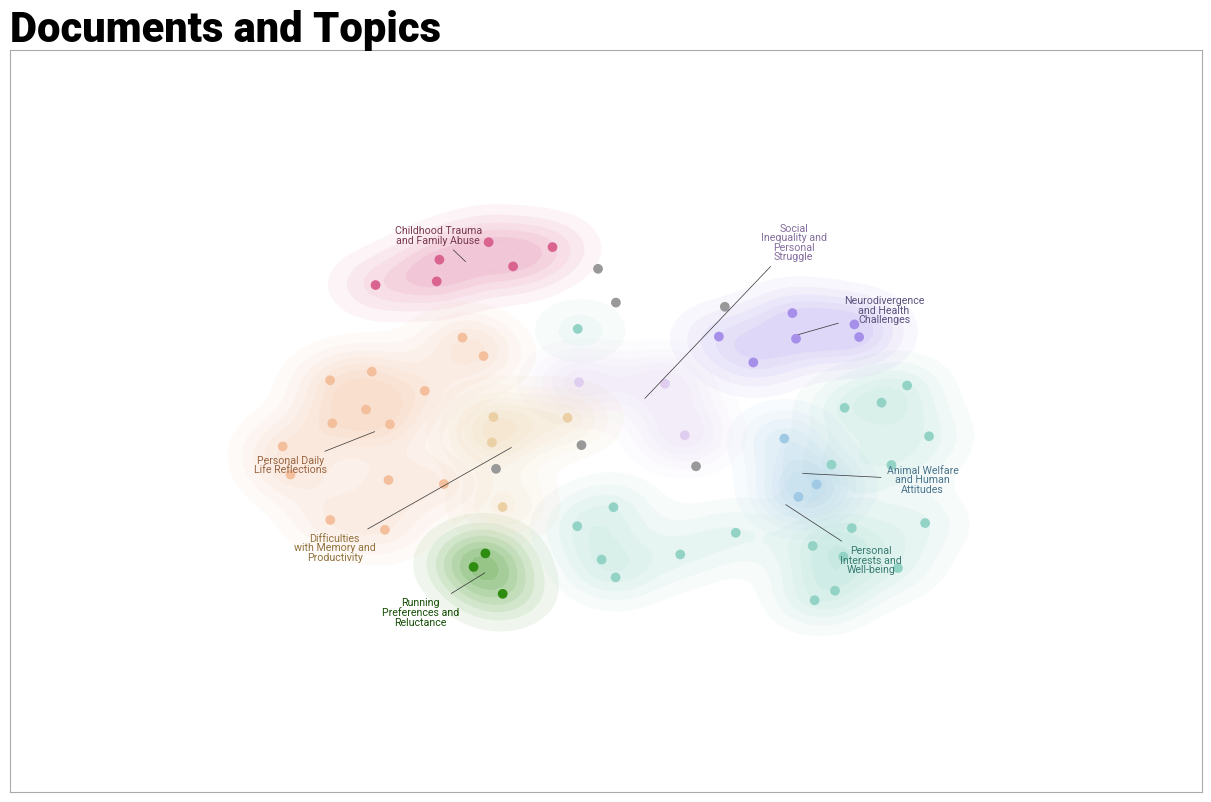

Translating topic words to English...

Translated Topics (Portuguese → English):
Topic 0: I adore, all, special, health, world
Topic 1: today, day, work, home, yet
Topic 2: adhd, there, continues, people, why
Topic 3: mother, memory, years, lots of, because
Topic 4: with you, accompanied, daily, to write, myself
Topic 5: to do, run, I like, , 
Topic 6: be, reasons, truly, trend, behavior
Topic 7: to live, times, where, so, lack
DEBUG: Available topics for plotting: [0, 1, 2, 3, 4, 5]
DEBUG: Topic 0 -> Label: Personal Interests and Well-being
DEBUG: Topic 1 -> Label: Personal Daily Life Reflections
DEBUG: Topic 2 -> Label: Neurodivergence and Health Challenges
DEBUG: Topic 3 -> Label: Childhood Trauma and Family Abuse
DEBUG: Topic 4 -> Label: Difficulties with Memory and Productivity
DEBUG: Topic 5 -> Label: Running Preferences and Reluctance
🔧 Applying translated_barchart specific optimizations...
🖼️  Saved bertopic_translated_barchart_Female_ADHD as PNG: 20250815_010909_bertopic_trans

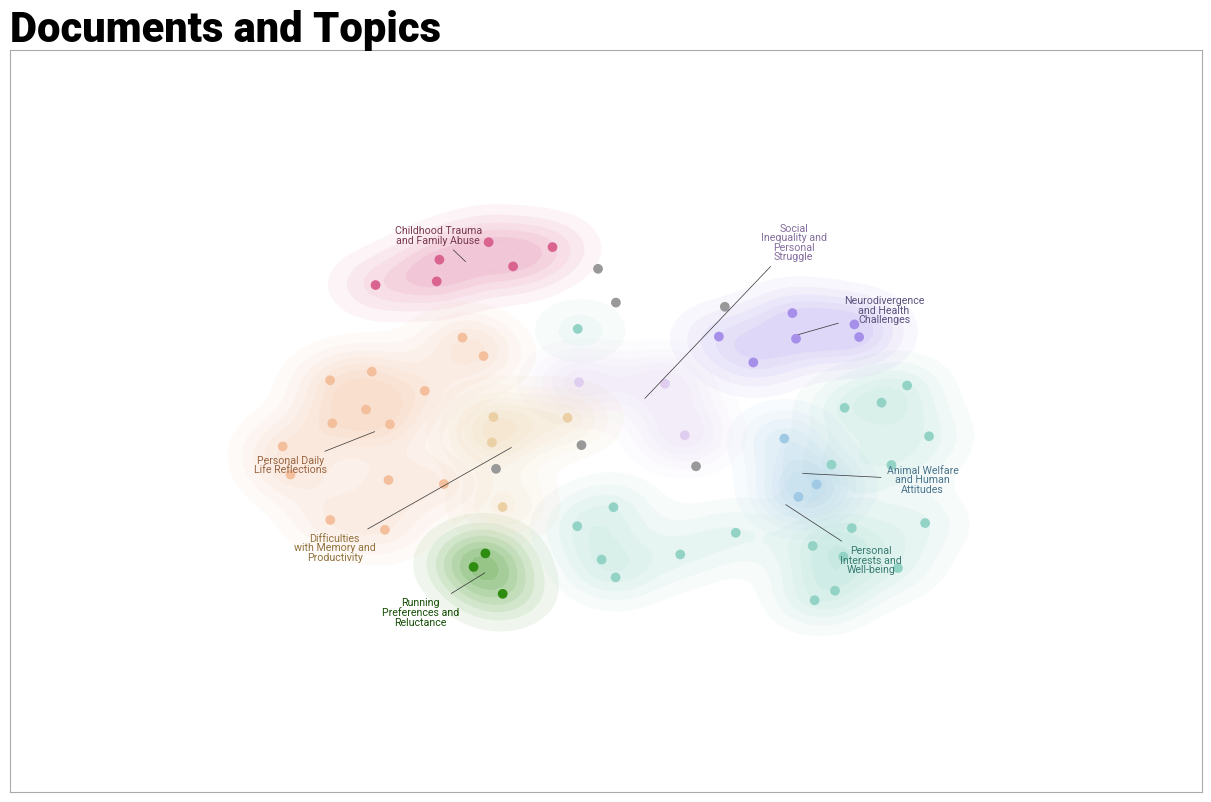

In [21]:
run_bertopic_viz(topic_model, df_group, output_folder, "Female_ADHD")

## Other Participants

In [22]:
folder = next(f for f in folders if f.startswith("Others_"))
print(folder)
df_group, topic_model, output_folder = preliminary_steps(folder)
check_hierarchy(topic_model, df_group, output_folder, "Others")

Others_20250814_235513_2
Running preliminary steps for folder: Others_20250814_235513_2
Others


100%|██████████| 20/20 [00:00<00:00, 576.68it/s]


🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_Others as PNG: 20250815_010913_bertopic_hierarchy_others.png
📊 Saved bertopic_hierarchy_Others as HTML: 20250815_010913_bertopic_hierarchy_others.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Others'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Others_20250814_235513_2
------------------------------------------------------------


🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Others as PNG: 20250815_010915_bertopic_topics_others.png
📊 Saved bertopic_topics_Others as HTML: 20250815_010915_bertopic_topics_others.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Others'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Others_20250814_235513_2
------------------------------------------------------------


.
├─dia_hoje_fazer_porque_tempo
│    ├─dia_hoje_fazer_ir_tarde
│    │    ├─■──eventos_bom_dia_situações_aconteça ── Topic: 11
│    │    └─dia_hoje_fazer_tarde_ir
│    │         ├─dia_tarde_hoje_fazer_ir
│    │         │    ├─■──super_feliz_bom_nervoso_apresentação ── Topic: 13
│    │         │    └─dia_tarde_ir_hoje_fazer
│    │         │         ├─■──fazer_dia_tempo_trabalho_porque ── Topic: 2
│    │         │         └─■──tarde_ir_acordei_casa_hoje ── Topic: 0
│    │         └─■──todos dias_dias_dia_campo_ja ── Topic: 14
│    └─memória_anos_lembro_sempre_mim
│         ├─memória_anos_lembro_sempre_mim
│         │    ├─memória_anos_lembro_comigo_sempre
│         │    │    ├─■──capaz_exame_nunca_mim_memória ── Topic: 17
│         │    │    └─memória_anos_lembro_comigo_altura
│         │    │         ├─■──altura_dizer_anos_comigo_memória ── Topic: 1
│         │    │         └─■──memória_lembro_avós_anos_morte ── Topic: 4
│         │    └─phda_medo_medicação_pessoas_tipo
│         │      

In [23]:
topic_info = topic_model.get_topic_info()
display(topic_info)
topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)

Topic  Count                                      Name  \
0      -1     68          -1_faz_quero_confortável_pessoas   
1       0     39                   0_tarde_ir_acordei_casa   
2       1     33                1_altura_dizer_anos_comigo   
3       2     32                2_fazer_dia_tempo_trabalho   
4       3     20                  3_ler_livros_forma_gosto   
5       4     19                4_memória_lembro_avós_anos   
6       5     16                 5_sentir_dá_permite_gosto   
7       6     15       6_música_ouvir_musical_ouvir música   
8       7     15  7_física_políticas_interessante_política   
9       8     15                  8_jogos_jogar_jogo_gosto   
10      9     14            9_desporto_parte_gosto_futebol   
11     10     13         10_pessoas_medo_inteligência_onde   
12     11     11              11_eventos_bom_dia_situações   
13     12     11       12_responder_nenhuma_prefiro_ocorre   
14     13     10                13_super_feliz_bom_nervoso   
15     14      9              14_todos dias_dias_dia_campo   
16     15      9            15_phda_medicação_tipo_começar   
17     16      7         16_gosto_cozinhar_adoro_favoritas   
18     17      7                  17_capaz_exame_nunca_mim   
19     18      7     18_questionário_escrever_parece_vezes   
20     19      6                19_2014_defender_14_aceite   
21     20      6         20_gosto_utilizar_projeto_pequeno   

                                      CustomName  \
0                                  Outlier Topic   
1                Personal Daily Life Experiences   
2      Friendship Challenges and Personal Growth   
3             Daily Stress and Emotional Balance   
4                  Passion for Fictional Stories   
5               Memories, Loss, and Family Bonds   
6          Relaxation Through Outdoor Activities   
7            Personal Music Listening Experience   
8               Curiosity About World Mechanisms   
9         Passion for Games and Game Development   
10            Engaging Sports and Fantasy Gaming   
11         Social Anxiety and Political Concerns   
12           Emotional Responses to Daily Events   
13       Difficulty Answering Personal Questions   
14           Personal Achievement and Resilience   
15              Daily Experiences and Creativity   
16     ADHD Diagnosis and Medication Experiences   
17     Personal Pleasures and Nostalgic Memories   
18                Overcoming Academic Self-Doubt   
19               Mental Fatigue and Overthinking   
20  Firefighter Leadership and Knowledge Sharing   
21                  Creative Arts and Expression   

                                       Representation  \
0   [faz, quero, confortável, pessoas, conhecer, f...   
1   [tarde, ir, acordei, casa, hoje, pai, dia, alm...   
2   [altura, dizer, anos, comigo, memória, hoje, f...   
3   [fazer, dia, tempo, trabalho, porque, senti, c...   
4   [ler, livros, forma, gosto, histórias, saga, p...   
5   [memória, lembro, avós, anos, morte, sempre, a...   
6   [sentir, dá, permite, gosto, adoro, acalma, li...   
7   [música, ouvir, musical, ouvir música, músicas...   
8   [física, políticas, interessante, política, co...   
9   [jogos, jogar, jogo, gosto, sempre, desde pequ...   
10  [desporto, parte, gosto, futebol, geralmente, ...   
11  [pessoas, medo, inteligência, onde, tudo, aten...   
12  [eventos, bom, dia, situações, aconteça, raiva...   
13  [responder, nenhuma, prefiro, ocorre, pergunta...   
14  [super, feliz, bom, nervoso, apresentação, men...   
15  [todos dias, dias, dia, campo, ja, criativo, t...   
16  [phda, medicação, tipo, começar, tomar, estado...   
17  [gosto, cozinhar, adoro, favoritas, visitar, r...   
18  [capaz, exame, nunca, mim, memória, faculdade,...   
19  [questionário, escrever, parece, vezes, chegou...   
20  [2014, defender, 14, aceite, transmitir, conhe...   
21  [gosto, utilizar, projeto, pequeno, interesse,...   

                                              KeyBERT  \
0   [sentir

In [24]:
run_bertopic_evals(topic_model, df_group, output_folder)

Silhouette score calculated on 314 documents across 21 topics
Silhouette Score: 0.0475
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.4816
Individual Topic Coherences:
  Topic 0: -1.3217
  Topic 1: -1.3045
  Topic 2: -1.5115
  Topic 3: -1.5413
  Topic 4: -1.7512
  Topic 5: -1.7143
  Topic 6: -0.9398
  Topic 7: -1.1835
  Topic 8: -2.0113
  Topic 9: -1.6291
  Topic 10: -2.0518
  Topic 11: -1.7190
  Topic 12: -1.2989
  Topic 13: -1.5239
  Topic 14: -1.3606
  Topic 15: -1.4209
  Topic 16: -1.6716
  Topic 17: -1.6310
  Topic 18: -1.7110
  Topic 19: -0.2068
  Topic 20: -1.6104
Coherence results saved to ../../outputs/bertopic_results/Others_20250814_235513_2/


Number of texts: 382
Number of topics: 382


Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...     16   
1    Gosto de ver séries porque relatam relações sa...      3   
2    Campos de ferias. Temos que criar o campo todo...     14   
3    Taylor Swift, amo o seu liricismo e a maneira ...     -1   
4    Historia da arte \nÉ só tão interessante. Para...      7   
..                                                 ...    ...   
377                                                  —     -1   
378  As vezes aborrece-me ter de escrever/responder...     18   
379  Maiores dificuldades que sempre senti.. Concen...     10   
380  De momento, na minha cabeça, só rumino sobre o...     17   
381  Alguém me mande um milagre, I am going crazy, ...     -1   

                                         Name  \
0           16_gosto_cozinhar_adoro_favoritas   
1                    3_ler_livros_forma_gosto   
2                14_todos dias_dias_dia_campo   
3            -1_faz_quero_confortável_pessoas   
4    7_física_políticas_interessante_política   
..                                        ...   
377          -1_faz_quero_confortável_pessoas   
378     18_questionário_escrever_parece_vezes   
379         10_pessoas_medo_inteligência_onde   
380                  17_capaz_exame_nunca_mim   
381          -1_faz_quero_confortável_pessoas   

                                    CustomName  \
0    Personal Pleasures and Nostalgic Memories   
1                Passion for Fictional Stories   
2             Daily Experiences and Creativity   
3                                Outlier Topic   
4             Curiosity About World Mechanisms   
..                                         ...   
377                              Outlier Topic   
378            Mental Fatigue and Overthinking   
379      Social Anxiety and Political Concerns   
380             Overcoming Academic Self-Doubt   
381                              Outlier Topic   

                                        Representation  \
0    [gosto, cozinhar, adoro, favoritas, visitar, r...   
1    [ler, livros, forma, gosto, histórias, saga, p...   
2    [todos dias, dias, dia, campo, ja, criativo, t...   
3    [faz, quero, confortável, pessoas, conhecer, f...   
4    [física, políticas, interessante, política, co...   
..                                                 ...   
377  [faz, quero, confortável, pessoas, conhecer, f...   
378  [questionário, escrever, parece, vezes, chegou...   
379  [pessoas, medo, inteligência, onde, tudo, aten...   
380  [capaz, exame, nunca, mim, memória, faculdade,...   
381  [faz, quero, confortável, pessoas, conhecer, f...   

                                               KeyBERT  \
0    [cozinhar, porque gosto, doces, receitas, gost...   
1    [livros, livro, ler, ficção, gosto porque, his...   
2    [trabalho senti, tempo, ando, aborrecido, últi...   
3    [sentir, viajar, memórias, memória, experiênci...   
4    [várias técnicas, políticas, técnicas, assunto...   
..                                                 ...   
377  [sentir, viajar, memórias, memória, experiênci...   
378  [stressar, muitas vezes, escrever, fico, dific...   
379  [sinto cérebro, vezes medo, mim sinto, maiorit...   
380  [stressar, tentar acabar, mim própria, aulas, ...   
381  [sentir, viajar, memórias, memória, experiênci...   

                                          OpenAI  \
0    [Personal Pleasures and Nostalgic Memories]   
1                [Passion for Fictional Stories]   
2             [Daily Experiences and Creativity]   
3          [Personal Growth Through Experiences]   
4             [Curiosity About World Mechanisms]   
..                                           ...   
377        [Personal Growth Through Experiences]   
378            [Mental Fatigue and Overthinking]   
379      [Social Anxiety and Political Concerns]   
380             [Overcoming Academic Self-Doubt]   
381        [Personal Growth Through Experiences]   

                                                   MMR  

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Others as PNG: 20250815_010917_bertopic_heatmap_others.png
📊 Saved bertopic_heatmap_Others as HTML: 20250815_010917_bertopic_heatmap_others.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Others'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Others_20250814_235513_2
------------------------------------------------------------


4it [00:00, 96.62it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Others as PNG: 20250815_010918_bertopic_topics_per_class_others.png
📊 Saved bertopic_topics_per_class_Others as HTML: 20250815_010918_bertopic_topics_per_class_others.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Others'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Others_20250814_235513_2
------------------------------------------------------------


🖼️  Saved bertopic_document_datamap_Others as PNG: 20250815_010923_bertopic_document_datamap_others.png
📊 Saved bertopic_document_datamap_Others as HTML: 20250815_010923_bertopic_document_datamap_others.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Others'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Others_20250814_235513_2
------------------------------------------------------------


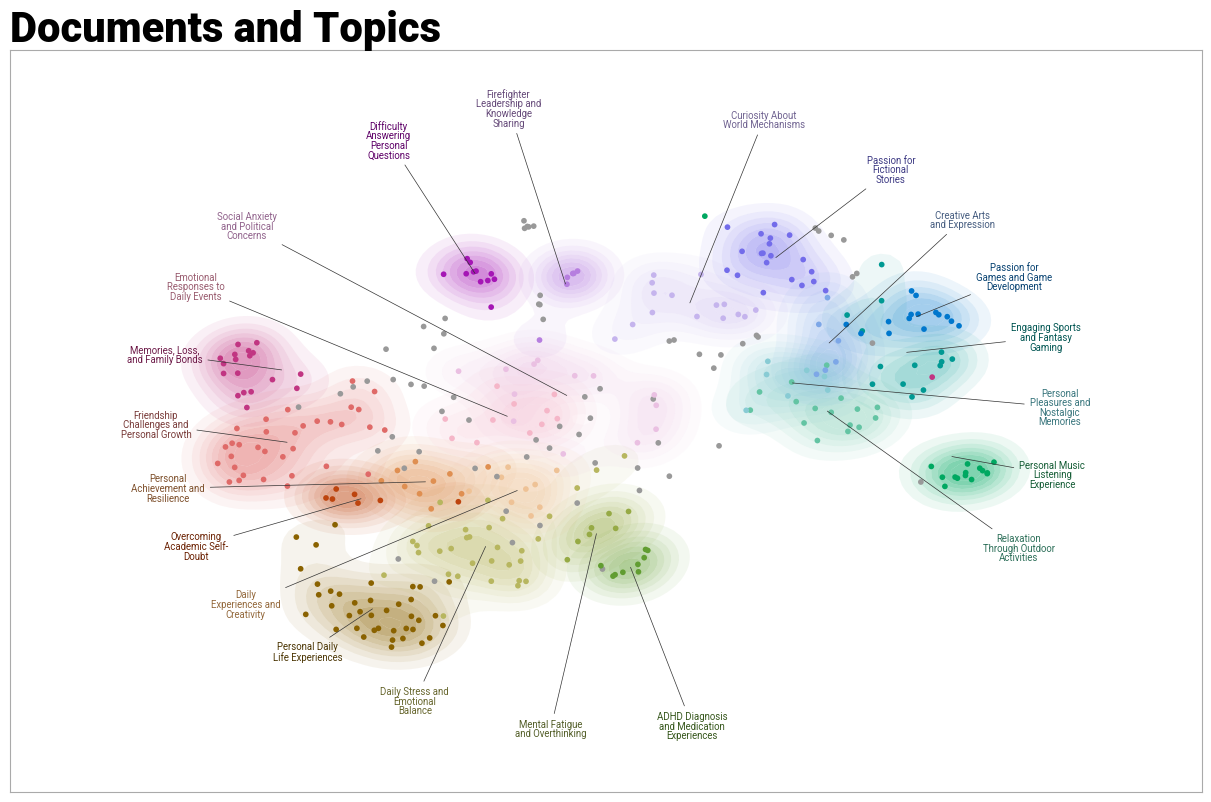

Translating topic words to English...

Translated Topics (Portuguese → English):
Topic 0: afternoon, go, I woke up, home, today
Topic 1: height, to say, years, with me, memory
Topic 2: to do, day, time, work, why
Topic 3: to read, books, shape, I like, stories
Topic 4: memory, I remember, grandparents, years, death
Topic 5: to feel, from the, allow, I like, I adore
Topic 6: music, to hear, musical, listen, songs
Topic 7: physical, policies, interesting, policy, body
Topic 8: games, to play, game, I like, always
Topic 9: sport, part, I like, soccer, generally
Topic 10: people, fear, intelligence, where, all
Topic 11: events, good, day, situations, happen
Topic 12: to respond, none, I prefer, occur, question
Topic 13: super, happy, good, nervous, presentation
Topic 14: every day, days, day, field, already
Topic 15: adhd, medication, type, to start, take
Topic 16: I like, to cook, I adore, favorite, visit
Topic 17: able, exam, never, me, memory
Topic 18: questionnaire, to write, like, tim

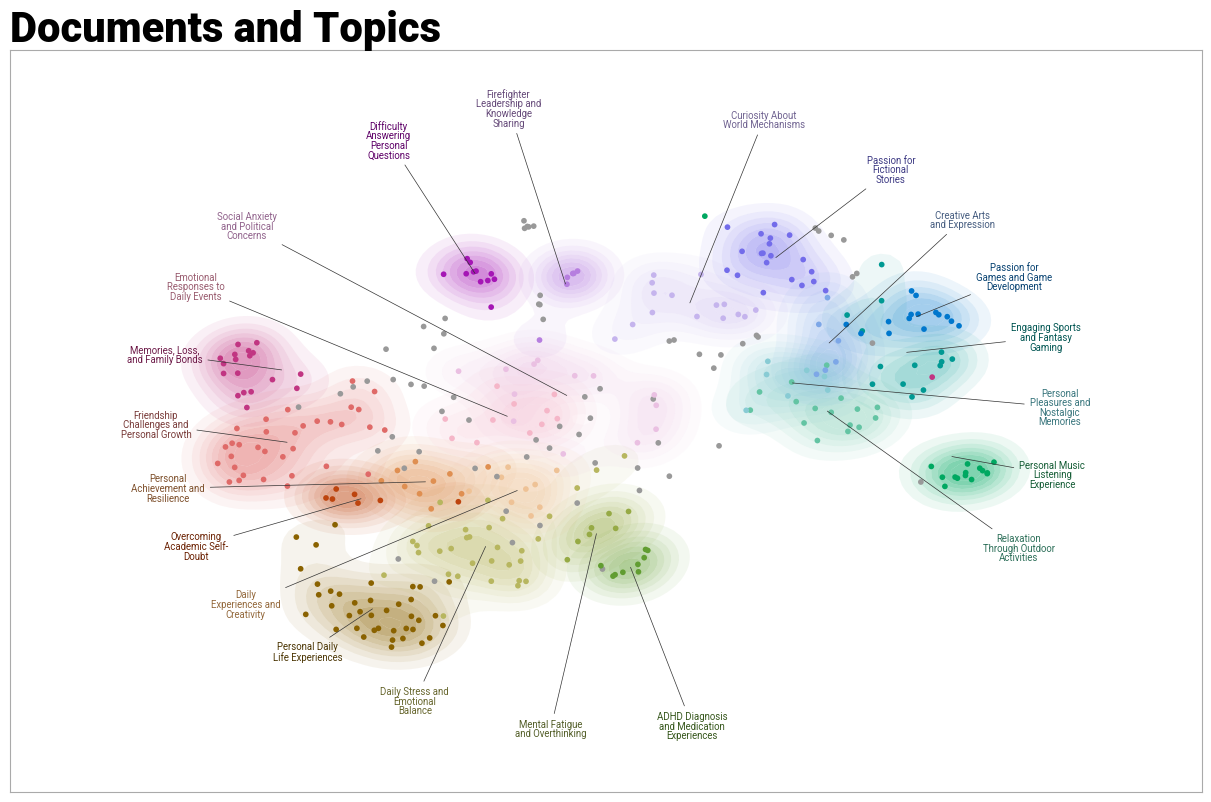

In [25]:
run_bertopic_viz(topic_model, df_group, output_folder, "Others")

## Female non-ADHD

In [26]:
folder = next(f for f in folders if f.startswith("Female_noADHD_"))
print(folder)
df_group, topic_model, output_folder = preliminary_steps(folder)
check_hierarchy(topic_model, df_group, output_folder, "Female_noADHD")

Female_noADHD_20250814_235513_2
Running preliminary steps for folder: Female_noADHD_20250814_235513_2
Female_noADHD


100%|██████████| 14/14 [00:00<00:00, 548.26it/s]


🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_Female_noADHD as PNG: 20250815_011011_bertopic_hierarchy_female_noadhd.png
📊 Saved bertopic_hierarchy_Female_noADHD as HTML: 20250815_011011_bertopic_hierarchy_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_noADHD_20250814_235513_2
------------------------------------------------------------


🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_noADHD as PNG: 20250815_011012_bertopic_topics_female_noadhd.png
📊 Saved bertopic_topics_Female_noADHD as HTML: 20250815_011012_bertopic_topics_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_noADHD_20250814_235513_2
------------------------------------------------------------


.
├─■──responder_prefiro_biblioteca_nenhuma_escrita ── Topic: 8
└─porque_dia_fazer_gosto_pessoas
     ├─gosto_pessoas_porque_música_anos
     │    ├─lembro_memórias_escolher_emoções_dia
     │    │    ├─■──mulher_lembro_mãe_memória_escolher ── Topic: 13
     │    │    └─■──memórias_emoções_dia_bom_felicidade ── Topic: 4
     │    └─gosto_pessoas_música_porque_anos
     │         ├─gosto_adoro_viajar_pessoas_sentir
     │         │    ├─■──gosto_adoro_cozinhar_acalma_bem ── Topic: 1
     │         │    └─■──gosto_viajar_novas_pessoas_sentir ── Topic: 9
     │         └─música_pessoas_anos_sempre_porque
     │              ├─forma_pessoas_anos_porque_ler
     │              │    ├─■──pessoas_atenção_medo_escrever_portugal ── Topic: 6
     │              │    └─forma_anos_porque_ler_memória
     │              │         ├─ler_forma_porque_interesse_dizer
     │              │         │    ├─■──ler_forma_interesse_livros_gosto ── Topic: 0
     │              │         │    └─■──dizer_falar

In [27]:
## PERFORM MANUAL TOPIC MERGE

# topics_to_merge = [[5, 11],
#                    [3, 1],
#                    [2, 9]]


# texts = df_group["response"].tolist()
# topic_model.merge_topics(texts, topics_to_merge)

In [28]:
topic_info = topic_model.get_topic_info()
display(topic_info)
topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)

Topic  Count                                    Name  \
0      -1     44                  -1_exame_fazer_dia_mim   
1       0     21            0_ler_forma_interesse_livros   
2       1     18           1_gosto_adoro_cozinhar_acalma   
3       2     18                2_porque_fazer_dia_quero   
4       3     13               3_memória_anos_morte_ouro   
5       4     12              4_memórias_emoções_dia_bom   
6       5     12                   5_pai_hoje_almoço_dia   
7       6     12         6_pessoas_atenção_medo_escrever   
8       7     11             7_dizer_falar_outros_altura   
9       8     11  8_responder_prefiro_biblioteca_nenhuma   
10      9     11            9_gosto_viajar_novas_pessoas   
11     10     10           10_filme_situação_hoje_cinema   
12     11      9          11_música_ouvir_tocar_enquanto   
13     12      8       12_pensamentos_muitas_algum_vezes   
14     13      6            13_mulher_lembro_mãe_memória   
15     14      4         14_feliz_hoje_trabalho_hoje dia   

                                    CustomName  \
0                                Outlier Topic   
1            Passion for Stories and Mythology   
2             Relaxation and Enjoyable Hobbies   
3      Stress and Daily Productivity Struggles   
4   Grandparents, Loss, and Childhood Memories   
5    Emotionally Significant Personal Memories   
6             Daily Life and Family Challenges   
7   Social Change, Gender, Technology Concerns   
8      Personal Anxiety and Social Experiences   
9               Refusal or Inability to Answer   
10           Personal Passions and Experiences   
11     Personal Challenges and Social Dynamics   
12                Personal Connection to Music   
13         Anxiety and Self-Acceptance Journey   
14             Women's Identity and Motherhood   
15            Daily Wellbeing and Productivity   

                                       Representation  \
0   [exame, fazer, dia, mim, nunca, ver, ano, aula...   
1   [ler, forma, interesse, livros, gosto, músicas...   
2   [gosto, adoro, cozinhar, acalma, bem, permite,...   
3   [porque, fazer, dia, quero, semana, ir, tempo,...   
4   [memória, anos, morte, ouro, infância, lembro,...   
5   [memórias, emoções, dia, bom, felicidade, mau,...   
6   [pai, hoje, almoço, dia, tarde, acordei, comec...   
7   [pessoas, atenção, medo, escrever, portugal, m...   
8   [dizer, falar, outros, altura, amiga, amigo, i...   
9   [responder, prefiro, biblioteca, nenhuma, escr...   
10  [gosto, viajar, novas, pessoas, sentir, mundo,...   
11  [filme, situação, hoje, cinema, dormi, super, ...   
12  [música, ouvir, tocar, enquanto, tanto, aprend...   
13  [pensamentos, muitas, algum, vezes, perceber, ...   
14  [mulher, lembro, mãe, memória, escolher, desde...   
15  [feliz, hoje, trabalho, hoje dia, dia, continu...   

                                              KeyBERT  \
0   [fiquei, aulas, altura, aula, mim, senti, faze...   
1   [livros, ler, histórias, especialmente, lido, ...   
2   [adoro fazer, sentir bem, gosto nadar, pratiqu...   
3   [stress, stressada, acordei, fiquei, senti, se...   
4   [cresci, memória, memória vem, conheci, durant...   
5   [memórias, esqueço, senti, emoções, chorei, se...   
6   [acordei tarde, hoje acordei, comecei dia, aco...   
7   [influência, mexer, mim sinto, dificuldades, p...   
8   [ansiedade, medo, comigo, achava, ia, memória,...   
9   [prefiro, responder, escrita, nenhuma, pergunt...   
10  [viajar, saudades, sentir, viver, fazer sentir...   
11  [fiquei desiludida, dormi, deixaram, ultimamen...   
12  [música, musical, tocar, ouvir, faço, ritmo, a...   
13  [mental, ansiedade, pensamentos, cansativo, co...   
14  [memória, memória lembro, tendo, sentimento, a...   
15  [trabalho senti, continuar trabalhar, decidi, ...   

                                          OpenAI  \
0       [Personal Challenges and Self-Discovery]   
1            [Passion for Stories and Mythology]   
2             [Relaxation and Enjoya

In [29]:
run_bertopic_evals(topic_model, df_group, output_folder)

Silhouette score calculated on 176 documents across 15 topics
Silhouette Score: 0.0331
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.3422
Individual Topic Coherences:
  Topic 0: -1.2413
  Topic 1: -1.3863
  Topic 2: -1.6017
  Topic 3: -1.2433
  Topic 4: -1.5558
  Topic 5: -1.2199
  Topic 6: -1.5587
  Topic 7: -1.5029
  Topic 8: -0.9940
  Topic 9: -1.3605
  Topic 10: -1.1368
  Topic 11: -0.9553
  Topic 12: -1.6491
  Topic 13: -1.2092
  Topic 14: -1.5176
Coherence results saved to ../../outputs/bertopic_results/Female_noADHD_20250814_235513_2/


Number of texts: 220
Number of topics: 220


Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...      1   
1    Gosto de ver séries porque relatam relações sa...      0   
2    Campos de ferias. Temos que criar o campo todo...     -1   
3    Taylor Swift, amo o seu liricismo e a maneira ...      0   
4    Historia da arte \nÉ só tão interessante. Para...     -1   
..                                                 ...    ...   
215  A noção de que procuro ser sempre uma boa pess...     12   
216                                                  —      8   
217  As vezes aborrece-me ter de escrever/responder...     -1   
218  Maiores dificuldades que sempre senti.. Concen...      6   
219  Alguém me mande um milagre, I am going crazy, ...     -1   

                                       Name  \
0             1_gosto_adoro_cozinhar_acalma   
1              0_ler_forma_interesse_livros   
2                    -1_exame_fazer_dia_mim   
3              0_ler_forma_interesse_livros   
4                    -1_exame_fazer_dia_mim   
..                                      ...   
215       12_pensamentos_muitas_algum_vezes   
216  8_responder_prefiro_biblioteca_nenhuma   
217                  -1_exame_fazer_dia_mim   
218         6_pessoas_atenção_medo_escrever   
219                  -1_exame_fazer_dia_mim   

                                     CustomName  \
0              Relaxation and Enjoyable Hobbies   
1             Passion for Stories and Mythology   
2                                 Outlier Topic   
3             Passion for Stories and Mythology   
4                                 Outlier Topic   
..                                          ...   
215         Anxiety and Self-Acceptance Journey   
216              Refusal or Inability to Answer   
217                               Outlier Topic   
218  Social Change, Gender, Technology Concerns   
219                               Outlier Topic   

                                        Representation  \
0    [gosto, adoro, cozinhar, acalma, bem, permite,...   
1    [ler, forma, interesse, livros, gosto, músicas...   
2    [exame, fazer, dia, mim, nunca, ver, ano, aula...   
3    [ler, forma, interesse, livros, gosto, músicas...   
4    [exame, fazer, dia, mim, nunca, ver, ano, aula...   
..                                                 ...   
215  [pensamentos, muitas, algum, vezes, perceber, ...   
216  [responder, prefiro, biblioteca, nenhuma, escr...   
217  [exame, fazer, dia, mim, nunca, ver, ano, aula...   
218  [pessoas, atenção, medo, escrever, portugal, m...   
219  [exame, fazer, dia, mim, nunca, ver, ano, aula...   

                                               KeyBERT  \
0    [adoro fazer, sentir bem, gosto nadar, pratiqu...   
1    [livros, ler, histórias, especialmente, lido, ...   
2    [fiquei, aulas, altura, aula, mim, senti, faze...   
3    [livros, ler, histórias, especialmente, lido, ...   
4    [fiquei, aulas, altura, aula, mim, senti, faze...   
..                                                 ...   
215  [mental, ansiedade, pensamentos, cansativo, co...   
216  [prefiro, responder, escrita, nenhuma, pergunt...   
217  [fiquei, aulas, altura, aula, mim, senti, faze...   
218  [influência, mexer, mim sinto, dificuldades, p...   
219  [fiquei, aulas, altura, aula, mim, senti, faze...   

                                           OpenAI  \
0              [Relaxation and Enjoyable Hobbies]   
1             [Passion for Stories and Mythology]   
2        [Personal Challenges and Self-Discovery]   
3             [Passion for Stories and Mythology]   
4        [Personal Challenges and Self-Discovery]   
..                                            ...   
215         [Anxiety and Self-Acceptance Journey]   
216              [Refusal or Inability to Answer]   
217      [Personal Challenges and Self-Discovery]   
218  [Social Change, Gender, Technology Concerns]   
219      [Personal Challenges and Self-Discovery]   

                                                   MMR  

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_noADHD as PNG: 20250815_011014_bertopic_heatmap_female_noadhd.png
📊 Saved bertopic_heatmap_Female_noADHD as HTML: 20250815_011014_bertopic_heatmap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_noADHD_20250814_235513_2
------------------------------------------------------------


4it [00:00, 120.27it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_noADHD as PNG: 20250815_011016_bertopic_topics_per_class_female_noadhd.png
📊 Saved bertopic_topics_per_class_Female_noADHD as HTML: 20250815_011016_bertopic_topics_per_class_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_noADHD_20250814_235513_2
------------------------------------------------------------


🖼️  Saved bertopic_document_datamap_Female_noADHD as PNG: 20250815_011020_bertopic_document_datamap_female_noadhd.png
📊 Saved bertopic_document_datamap_Female_noADHD as HTML: 20250815_011020_bertopic_document_datamap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_noADHD_20250814_235513_2
------------------------------------------------------------


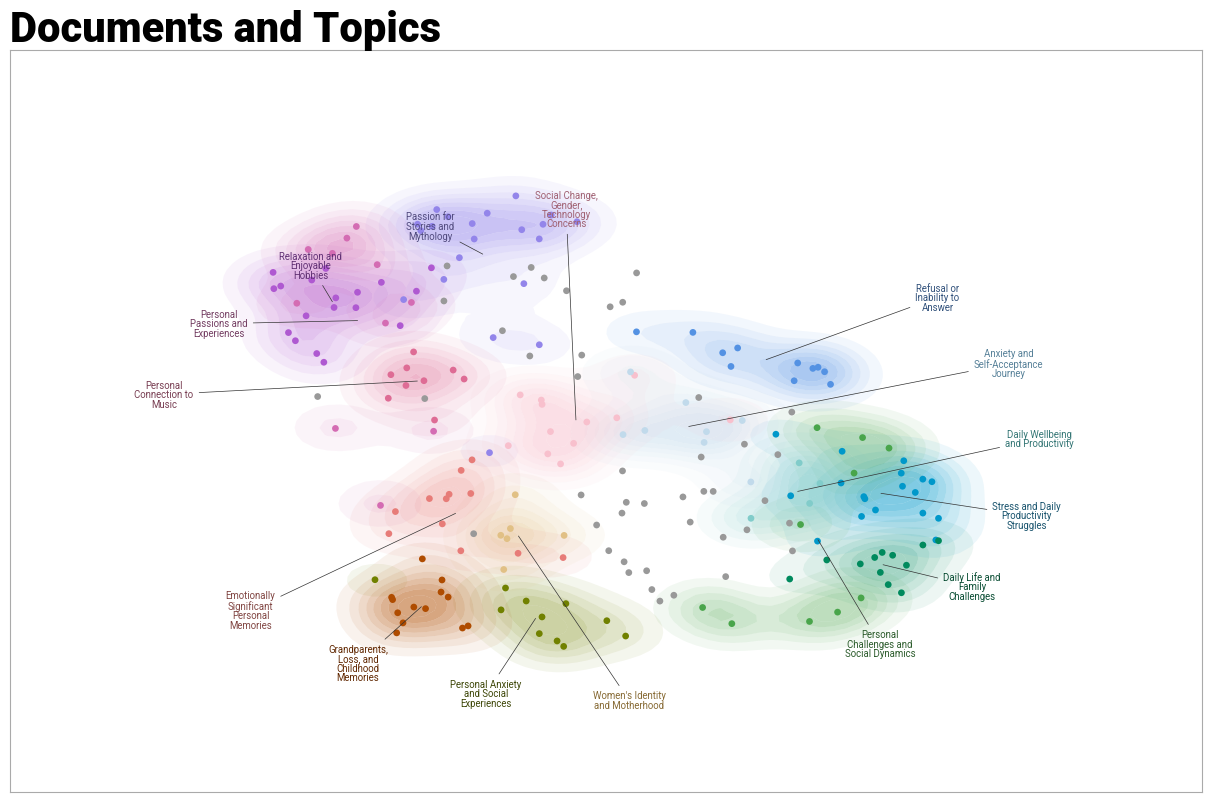

Translating topic words to English...

Translated Topics (Portuguese → English):
Topic 0: to read, shape, interest, books, I like
Topic 1: I like, I adore, to cook, calm, good
Topic 2: why, to do, day, I want, week
Topic 3: memory, years, death, gold, infancy
Topic 4: memories, emotions, day, good, happiness
Topic 5: father, today, lunch, day, afternoon
Topic 6: people, attention, fear, to write, Portugal
Topic 7: to say, to speak, others, height, friend
Topic 8: to respond, I prefer, library, none, writing
Topic 9: I like, travel, new, people, to feel
Topic 10: film, situation, today, cinema, Sleep
Topic 11: music, to hear, touch, while, both
Topic 12: thoughts, lots of, some, times, to perceive
Topic 13: woman, I remember, mother, memory, to choose
Topic 14: happy, today, work, today, day
DEBUG: Available topics for plotting: [0, 1, 2, 3, 4, 5]
DEBUG: Topic 0 -> Label: Passion for Stories and Mythology
DEBUG: Topic 1 -> Label: Relaxation and Enjoyable Hobbies
DEBUG: Topic 2 -> Label:

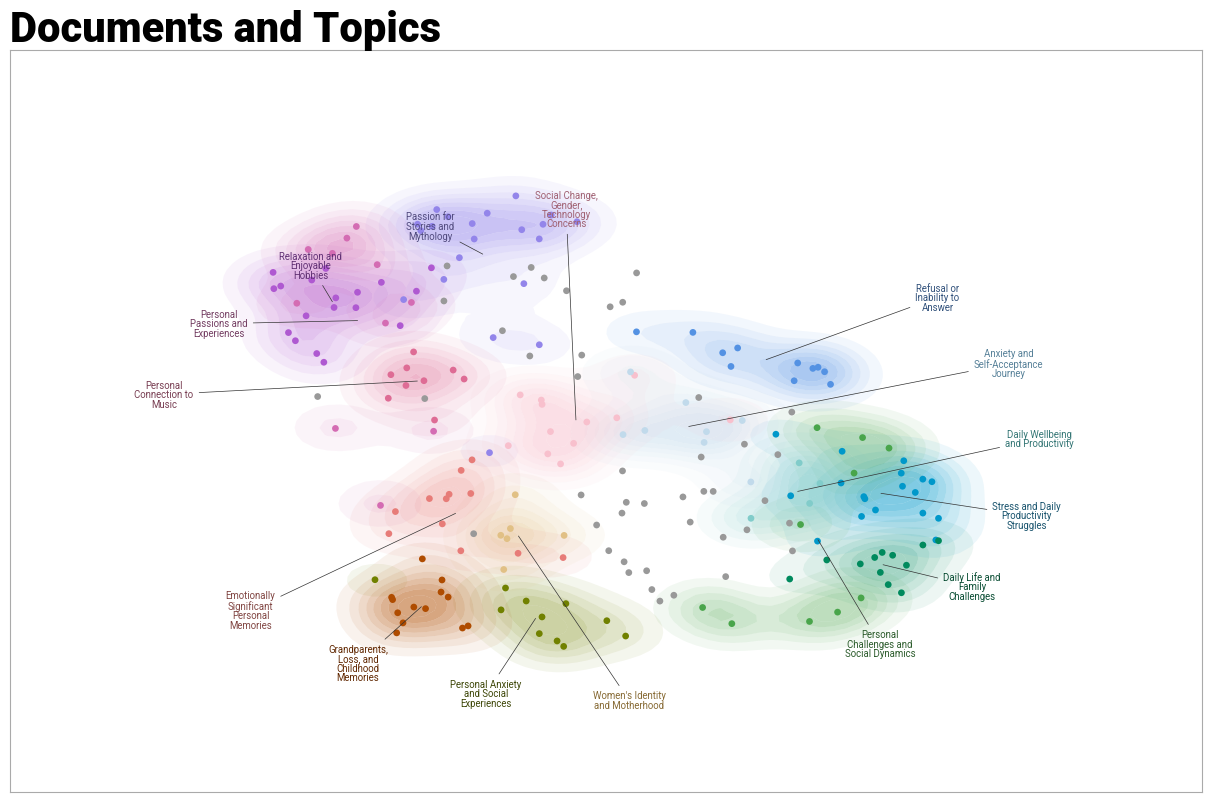

In [30]:
run_bertopic_viz(topic_model, df_group, output_folder, "Female_noADHD")

## Male ADHD

In [31]:
folder = next(f for f in folders if f.startswith("Male_ADHD_"))
print(folder)
df_group, topic_model, output_folder = preliminary_steps(folder)
check_hierarchy(topic_model, df_group, output_folder, "Male_ADHD")

Male_ADHD_20250814_235513_2
Running preliminary steps for folder: Male_ADHD_20250814_235513_2
Male_ADHD


100%|██████████| 6/6 [00:00<00:00, 517.28it/s]


🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_Male_ADHD as PNG: 20250815_011054_bertopic_hierarchy_male_adhd.png
📊 Saved bertopic_hierarchy_Male_ADHD as HTML: 20250815_011054_bertopic_hierarchy_male_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Male_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_ADHD_20250814_235513_2
------------------------------------------------------------


🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Male_ADHD as PNG: 20250815_011055_bertopic_topics_male_adhd.png
📊 Saved bertopic_topics_Male_ADHD as HTML: 20250815_011055_bertopic_topics_male_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Male_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_ADHD_20250814_235513_2
------------------------------------------------------------


.
├─phda_semana_casa_pessoas_trabalho
│    ├─semana_hoje_trabalho_tarde_pessoas
│    │    ├─■──pessoas_empreendedorismo_contudo_super_porque ── Topic: 6
│    │    └─■──hoje_semana_casa_tarde_ainda ── Topic: 1
│    └─■──phda_medicação_sinto_poder_muitas ── Topic: 4
└─gosto_tudo_jogo_saber_algo
     ├─gosto_tudo_jogo_saber_algo
     │    ├─■──mim_dia_saber_ainda_sinto ── Topic: 3
     │    └─gosto_jogo_tudo_tipo_algo
     │         ├─■──gosto_jogo_algo_sempre_jogar ── Topic: 0
     │         └─■──tudo_melhor_saber_nível_tipo ── Topic: 5
     └─■──apenas_estudo_humana_etc_desde ── Topic: 2



In [32]:
topic_info = topic_model.get_topic_info()
display(topic_info)
topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)

Topic  Count                                      Name  \
0     -1      5             -1_tentar_vezes_qualquer_2025   
1      0      6                  0_gosto_jogo_algo_sempre   
2      1      5                  1_hoje_semana_casa_tarde   
3      2      3                2_apenas_estudo_humana_etc   
4      3      3                     3_mim_dia_saber_ainda   
5      4      3              4_phda_medicação_sinto_poder   
6      5      2                 5_tudo_melhor_saber_nível   
7      6      2  6_pessoas_empreendedorismo_contudo_super   

                                       CustomName  \
0                                   Outlier Topic   
1                  Personal Hobbies and Interests   
2               Daily Experiences with Adult ADHD   
3                  Human Thought, Art, Philosophy   
4             Personal Trauma and Self-Reflection   
5  ADHD, Depression, Diagnosis, Medication Access   
6              Neurodiversity and Broad Curiosity   
7        Academic Challenges and Entrepreneurship   

                                      Representation  \
0  [tentar, vezes, qualquer, 2025, 06, humana, me...   
1  [gosto, jogo, algo, sempre, jogar, fez, vezes,...   
2  [hoje, semana, casa, tarde, ainda, pois, nada,...   
3  [apenas, estudo, humana, etc, desde, perder, i...   
4  [mim, dia, saber, ainda, sinto, vem cabeça, am...   
5  [phda, medicação, sinto, poder, muitas, nível,...   
6  [tudo, melhor, saber, nível, tipo, pessoas, ba...   
7  [pessoas, empreendedorismo, contudo, super, po...   

                                             KeyBERT  \
0  [fazer, stressar, mentalmente, tempo, assunto,...   
1  [memórias, buscar, fazer, stressar, partir, jo...   
2  [hoje, tempo, ansioso, dia, tido, rotinas, dur...   
3  [várias, coisas, ideias, vida, estudo, etc, ba...   
4  [memórias, mim, sinto, tido, falta, partir, as...   
5  [phda, sinto, autismo, medicação, sair, bastan...   
6  [autismo, saber, coisas, etc, fazer, pessoas, ...   
7  [mentalmente, mim, número, ansioso, fazer, emp...   

                                             OpenAI  \
0                  [Human Mind, Effort, Rumination]   
1                  [Personal Hobbies and Interests]   
2               [Daily Experiences with Adult ADHD]   
3                  [Human Thought, Art, Philosophy]   
4             [Personal Trauma and Self-Reflection]   
5  [ADHD, Depression, Diagnosis, Medication Access]   
6              [Neurodiversity and Broad Curiosity]   
7        [Academic Challenges and Entrepreneurship]   

                                                 MMR  \
0  [tentar, vezes, 2025, mentalmente, imenso, str...   
1  [gosto, jogar, vezes, stressar, buscar, qualqu...   
2  [tarde, ainda, sair, falta, mim, phda, 2025, t...   
3  [estudo, etc, perder, pode, várias, coisas, pe...   
4  [ainda, sinto, amigo, memórias, partir, difíci...   
5  [phda, medicação, super, autismo, primeiro, di...   
6  [saber, tipo, autismo, etc, empreendedorismo, ...   
7  [empreendedorismo, vida, correu bem, universid...   

                                                 POS  Representative_Docs  
0  [vezes, tempos, humana, dias, assunto, dia, te...                  NaN  
1  [gosto, jogo, vezes, vez, tipo, procura, númer...                  NaN  
2  [semana, casa, tarde, trabalho, falta, anos, p...                  NaN  
3  [estudo, ideias, humana, pessoa, coisas, traba...                  NaN  
4  [dia, bocado, assunto, difícil, memórias, amig...                  NaN  
5  [medicação, poder, nível, super, vida, autismo...                  NaN  
6  [melhor, nível, tipo, pessoas, cada, autismo, ...                  NaN  
7  [pessoas, empreendedorismo, super, vez, trabal...                  NaN

In [33]:
run_bertopic_evals(topic_model, df_group, output_folder)

Silhouette score calculated on 24 documents across 7 topics
Silhouette Score: 0.0420
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -0.5425
Individual Topic Coherences:
  Topic 0: -0.4997
  Topic 1: -0.4865
  Topic 2: -0.6330
  Topic 3: -0.7445
  Topic 4: -0.4190
  Topic 5: -0.5090
  Topic 6: -0.5056
Coherence results saved to ../../outputs/bertopic_results/Male_ADHD_20250814_235513_2/


Number of texts: 29
Number of topics: 29


Document  Topic  \
0   Não estudo no sentido literal, mas interesso-m...      2   
1                                              Linux!     -1   
2   Gosto muito de arrumação gosto de ter tudo arr...      0   
3   Gosto imenso de montanhas russas, às vezes gos...      0   
4   Eu gosto de jogos repetitivos, pois são privis...      0   
5   Um dos meu intereses especiais é ark que é um ...      0   
6   Videografia/cinematografia é uma das áreas da ...      2   
7   Ultimamente, ando particularmente interessado ...      2   
8   Adoro "tudo" no geral, saber como tudo funcion...      5   
9   Literatura dos séculos XIX e XX. Há imensas hi...     -1   
10  Fui diagnosticado recentemente com depressão, ...      4   
11  Portanto são 23:06 já devia de estar a dormir ...      1   
12  Acordei de uma dormida muito curta, e não quer...      1   
13  hoje de manha fui a universidade ter RCR e foi...      1   
14  14 abril 2025\n\nHoje acordei pelas 8h, sabend...      1   
15  Cansado mentalmente  -  10/06/2025\n(Tema/Titu...     -1   
16  Provavelmente tentar ler e não conseguir. Tent...     -1   
17  Frequentemente vem-me à cabeça um episódio em ...      3   
18  Eu sinceramente não sei bem responder a este p...      3   
19  Há muitas memórias, uma delas é da primeira re...      0   
20  Genuinamente não sou capaz de me lembrar  de n...      0   
21  O meu gato faleceu quando tinha apenas 7 anos,...      1   
22  A memória que escolhi é a minha apresentação n...      6   
23  Não vou entrar em detalhes por ser um assunto ...      3   
24  Estou curioso com este estudo, pvf divulguem o...      4   
25  A cabeça está sempre como no redLine do carros...      5   
26  a capacidade da mente humana de desenvolver um...     -1   
27  Ouço muitas pessoas descrever a sua PHDA como ...      4   
28  De momento, na minha cabeça, só rumino sobre o...      6   

                                        Name  \
0                 2_apenas_estudo_humana_etc   
1              -1_tentar_vezes_qualquer_2025   
2                   0_gosto_jogo_algo_sempre   
3                   0_gosto_jogo_algo_sempre   
4                   0_gosto_jogo_algo_sempre   
5                   0_gosto_jogo_algo_sempre   
6                 2_apenas_estudo_humana_etc   
7                 2_apenas_estudo_humana_etc   
8                  5_tudo_melhor_saber_nível   
9              -1_tentar_vezes_qualquer_2025   
10              4_phda_medicação_sinto_poder   
11                  1_hoje_semana_casa_tarde   
12                  1_hoje_semana_casa_tarde   
13                  1_hoje_semana_casa_tarde   
14                  1_hoje_semana_casa_tarde   
15             -1_tentar_vezes_qualquer_2025   
16             -1_tentar_vezes_qualquer_2025   
17                     3_mim_dia_saber_ainda   
18                     3_mim_dia_saber_ainda   
19                  0_gosto_jogo_algo_sempre   
20                  0_gosto_jogo_algo_sempre   
21                  1_hoje_semana_casa_tarde   
22  6_pessoas_empreendedorismo_contudo_super   
23                     3_mim_dia_saber_ainda   
24              4_phda_medicação_sinto_poder   
25                 5_tudo_melhor_saber_nível   
26             -1_tentar_vezes_qualquer_2025   
27              4_phda_medicação_sinto_poder   
28  6_pessoas_empreendedorismo_contudo_super   

                                        CustomName  \
0                   Human Thought, Art, Philosophy   
1                                    Outlier Topic   
2                   Personal Hobbies and Interests   
3                   Personal Hobbies and Interests   
4                   Personal Hobbies and Interests   
5                   Personal Hobbies and Interests   
6                   Human Thought, Art, Philosophy   
7                   Human Thought, Art, Philosophy   
8               Neurodiversity and Broad Curiosity   
9                                    Outlier Topic   
10  ADHD, Depression, Diagnosis, Medication Access   
11               Daily Experiences 

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Male_ADHD as PNG: 20250815_011057_bertopic_heatmap_male_adhd.png
📊 Saved bertopic_heatmap_Male_ADHD as HTML: 20250815_011057_bertopic_heatmap_male_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Male_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_ADHD_20250814_235513_2
------------------------------------------------------------


4it [00:00, 207.44it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Male_ADHD as PNG: 20250815_011059_bertopic_topics_per_class_male_adhd.png
📊 Saved bertopic_topics_per_class_Male_ADHD as HTML: 20250815_011059_bertopic_topics_per_class_male_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Male_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_ADHD_20250814_235513_2
------------------------------------------------------------


🖼️  Saved bertopic_document_datamap_Male_ADHD as PNG: 20250815_011102_bertopic_document_datamap_male_adhd.png
📊 Saved bertopic_document_datamap_Male_ADHD as HTML: 20250815_011102_bertopic_document_datamap_male_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Male_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_ADHD_20250814_235513_2
------------------------------------------------------------


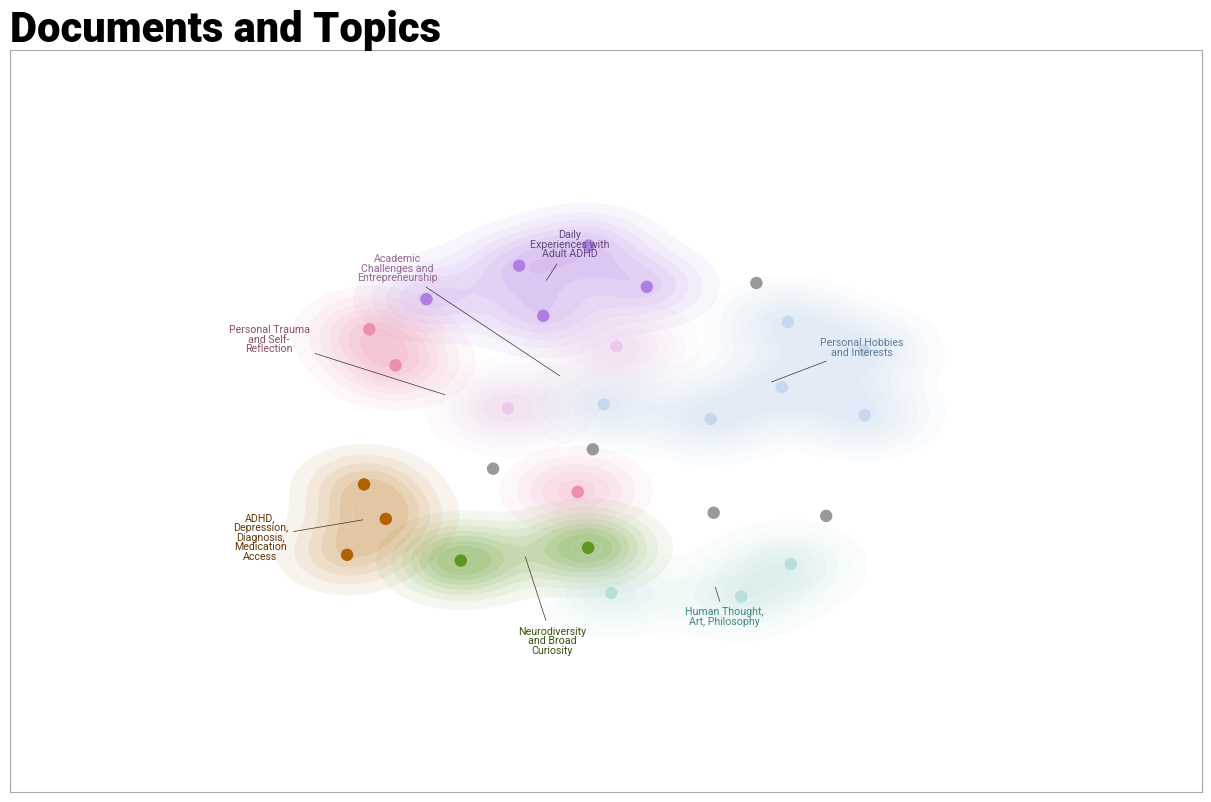

Translating topic words to English...

Translated Topics (Portuguese → English):
Topic 0: I like, game, something, always, to play
Topic 1: today, week, home, afternoon, yet
Topic 2: just, study, human, etc, since
Topic 3: me, day, to know, yet, I feel
Topic 4: adhd, medication, I feel, power, lots of
Topic 5: all, better, to know, level, type
Topic 6: people, entrepreneurship, however, super, why
DEBUG: Available topics for plotting: [0, 1, 2, 3, 4, 5]
DEBUG: Topic 0 -> Label: Personal Hobbies and Interests
DEBUG: Topic 1 -> Label: Daily Experiences with Adult ADHD
DEBUG: Topic 2 -> Label: Human Thought, Art, Philosophy
DEBUG: Topic 3 -> Label: Personal Trauma and Self-Reflection
DEBUG: Topic 4 -> Label: ADHD, Depression, Diagnosis, Medication Access
DEBUG: Topic 5 -> Label: Neurodiversity and Broad Curiosity
🔧 Applying translated_barchart specific optimizations...
🖼️  Saved bertopic_translated_barchart_Male_ADHD as PNG: 20250815_011114_bertopic_translated_barchart_male_adhd.png
📊 Sav

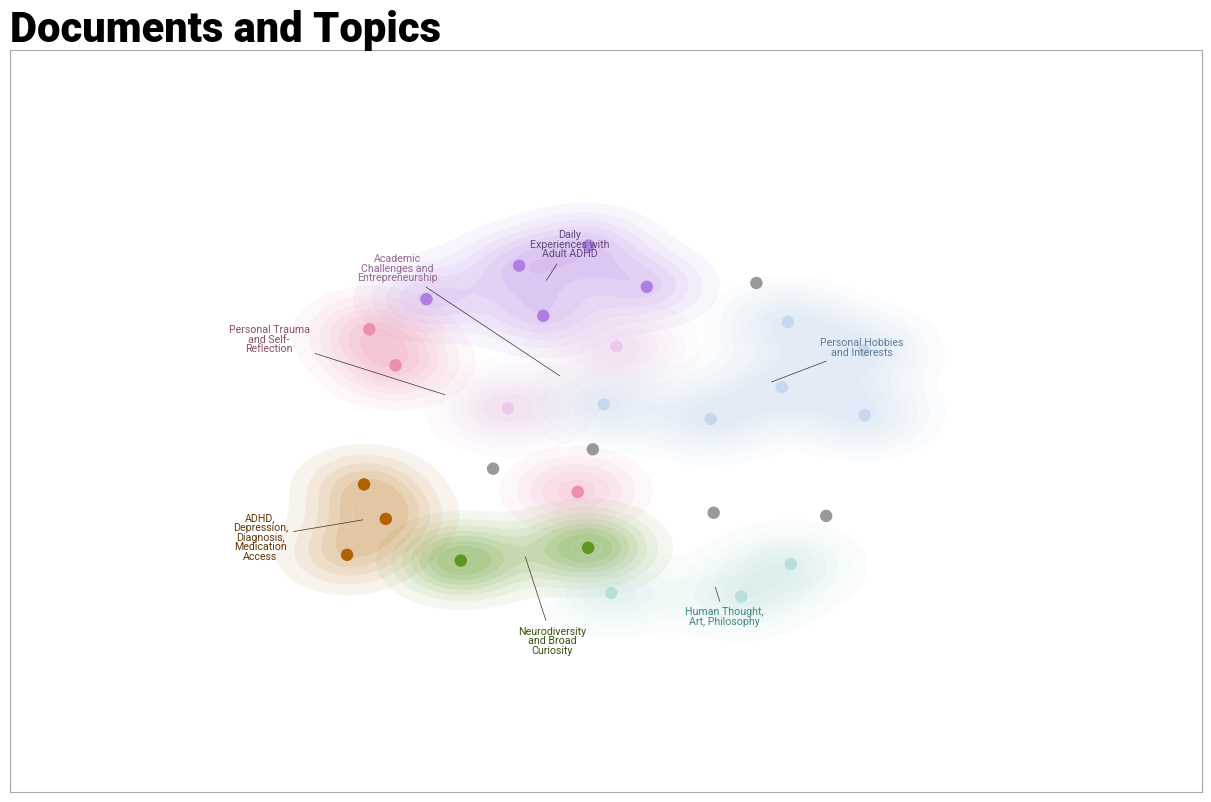

In [34]:
run_bertopic_viz(topic_model, df_group, output_folder, "Male_ADHD")

## Male non-ADHD

In [35]:
folder = next(f for f in folders if f.startswith("Male_noADHD_"))
print(folder)
df_group, topic_model, output_folder = preliminary_steps(folder)
check_hierarchy(topic_model, df_group, output_folder, "Male_noADHD")

Male_noADHD_20250814_235513_2
Running preliminary steps for folder: Male_noADHD_20250814_235513_2
Male_noADHD


100%|██████████| 5/5 [00:00<00:00, 526.75it/s]


🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_Male_noADHD as PNG: 20250815_011118_bertopic_hierarchy_male_noadhd.png
📊 Saved bertopic_hierarchy_Male_noADHD as HTML: 20250815_011118_bertopic_hierarchy_male_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Male_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_noADHD_20250814_235513_2
------------------------------------------------------------


🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Male_noADHD as PNG: 20250815_011120_bertopic_topics_male_noadhd.png
📊 Saved bertopic_topics_Male_noADHD as HTML: 20250815_011120_bertopic_topics_male_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Male_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_noADHD_20250814_235513_2
------------------------------------------------------------


.
├─■──melhor amigo_aceite_causa_falecimento_amigo ── Topic: 5
└─dia_fazer_algo_porque_hoje
     ├─música_escrever_detalhe_ouvir_gosto
     │    ├─■──escrever_detalhe_sinto confortável_confortável_sinto ── Topic: 3
     │    └─■──música_ouvir_gostos_gosto_bastante ── Topic: 4
     └─dia_fazer_hoje_porque_algo
          ├─dia_fazer_porque_ir_hoje
          │    ├─■──desporto_gosto_sentir_porque_dia ── Topic: 1
          │    └─■──dia_hoje_fazer_ir_porque ── Topic: 0
          └─■──jogos_história_jogar_anime_gosto ── Topic: 2



In [36]:
topic_info = topic_model.get_topic_info()
display(topic_info)
topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)

Topic  Count                                              Name  \
0      0     67                               0_dia_hoje_fazer_ir   
1      1     25                    1_desporto_gosto_sentir_porque   
2      2     15                      2_jogos_história_jogar_anime   
3      3     12  3_escrever_detalhe_sinto confortável_confortável   
4      4      7                       4_música_ouvir_gostos_gosto   
5      5      7           5_melhor amigo_aceite_causa_falecimento   

                                   CustomName  \
0     Daily Routines and Personal Reflections   
1            Personal Experiences with Sports   
2         Creative Gaming and Anime Interests   
3         Discomfort Writing Sensitive Topics   
4  Personal Music Preferences and Experiences   
5              Loss and Commitment to Service   

                                      Representation  \
0  [dia, hoje, fazer, ir, porque, algo, tempo, co...   
1  [desporto, gosto, sentir, porque, dia, usar, a...   
2  [jogos, história, jogar, anime, gosto, interes...   
3  [escrever, detalhe, sinto confortável, confort...   
4  [música, ouvir, gostos, gosto, bastante, prime...   
5  [melhor amigo, aceite, causa, falecimento, ami...   

                                             KeyBERT  \
0  [fiquei, memória, senti, altura, tempo, acabei...   
1  [gosto fazer, praticar, aproveitar, mim, fazer...   
2  [gosto jogar, game dev, jogos, gostar tanto, g...   
3  [discutir, escrever, situações, pessoal, senti...   
4  [música, ouvir, sentir, sinto, emoções, sentir...   
5                               [, , , , , , , , , ]   

                                         OpenAI  \
0     [Daily Routines and Personal Reflections]   
1            [Personal Experiences with Sports]   
2         [Creative Gaming and Anime Interests]   
3         [Discomfort Writing Sensitive Topics]   
4  [Personal Music Preferences and Experiences]   
5              [Loss and Commitment to Service]   

                                                 MMR  \
0  [hoje, tempo, coisas, amigos, senti, apesar, m...   
1  [desporto, sentir, usar, quero, especial, faze...   
2  [jogos, história, anime, interesse especial, a...   
3  [escrever, detalhe, sinto confortável, situaçõ...   
4  [música, ouvir, gostos, primeira, outros, escr...   
5  [melhor amigo, aceite, causa, falecimento, ami...   

                                                 POS  Representative_Docs  
0  [dia, tempo, coisas, amigos, memória, melhor, ...                  NaN  
1  [desporto, gosto, dia, poder, melhor, especial...                  NaN  
2  [jogos, história, anime, gosto, interesse, jog...                  NaN  
3  [detalhe, confortável, situações, tipo, intere...                  NaN  
4  [música, gostos, gosto, primeira, momento, cab...                  NaN  
5   [melhor amigo, causa, amigo, melhor, , , , , , ]                  NaN

In [37]:
run_bertopic_evals(topic_model, df_group, output_folder)

Silhouette score calculated on 133 documents across 6 topics
Silhouette Score: 0.0740
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.2198
Individual Topic Coherences:
  Topic 0: -1.2614
  Topic 1: -1.7638
  Topic 2: -1.2848
  Topic 3: -1.4115
  Topic 4: -1.2126
  Topic 5: -0.3846
Coherence results saved to ../../outputs/bertopic_results/Male_noADHD_20250814_235513_2/


Number of texts: 133
Number of topics: 133


Document  Topic  \
0    Senhor dos anéis pelo expansivo mundo, históri...      1   
1    Jogos no geral, adoro aprender e perceber mecâ...      2   
2    Música e como certos sons e instrumentos me fa...      4   
3    Video jogos, independentemente do género, gost...      2   
4       Adivinhar os dias da semana com base numa data      0   
..                                                 ...    ...   
128                                                  .      5   
129  Existem primatas que usam utensílios básicos c...      1   
130  Quero dormir. Quero deitar-me numa cama e apag...      1   
131  Física quântica para mim é super interessante ...      1   
132  Outras características minhas que possam ser r...      0   

                                        Name  \
0             1_desporto_gosto_sentir_porque   
1               2_jogos_história_jogar_anime   
2                4_música_ouvir_gostos_gosto   
3               2_jogos_história_jogar_anime   
4                        0_dia_hoje_fazer_ir   
..                                       ...   
128  5_melhor amigo_aceite_causa_falecimento   
129           1_desporto_gosto_sentir_porque   
130           1_desporto_gosto_sentir_porque   
131           1_desporto_gosto_sentir_porque   
132                      0_dia_hoje_fazer_ir   

                                     CustomName  \
0              Personal Experiences with Sports   
1           Creative Gaming and Anime Interests   
2    Personal Music Preferences and Experiences   
3           Creative Gaming and Anime Interests   
4       Daily Routines and Personal Reflections   
..                                          ...   
128              Loss and Commitment to Service   
129            Personal Experiences with Sports   
130            Personal Experiences with Sports   
131            Personal Experiences with Sports   
132     Daily Routines and Personal Reflections   

                                        Representation  \
0    [desporto, gosto, sentir, porque, dia, usar, a...   
1    [jogos, história, jogar, anime, gosto, interes...   
2    [música, ouvir, gostos, gosto, bastante, prime...   
3    [jogos, história, jogar, anime, gosto, interes...   
4    [dia, hoje, fazer, ir, porque, algo, tempo, co...   
..                                                 ...   
128  [melhor amigo, aceite, causa, falecimento, ami...   
129  [desporto, gosto, sentir, porque, dia, usar, a...   
130  [desporto, gosto, sentir, porque, dia, usar, a...   
131  [desporto, gosto, sentir, porque, dia, usar, a...   
132  [dia, hoje, fazer, ir, porque, algo, tempo, co...   

                                               KeyBERT  \
0    [gosto fazer, praticar, aproveitar, mim, fazer...   
1    [gosto jogar, game dev, jogos, gostar tanto, g...   
2    [música, ouvir, sentir, sinto, emoções, sentir...   
3    [gosto jogar, game dev, jogos, gostar tanto, g...   
4    [fiquei, memória, senti, altura, tempo, acabei...   
..                                                 ...   
128                               [, , , , , , , , , ]   
129  [gosto fazer, praticar, aproveitar, mim, fazer...   
130  [gosto fazer, praticar, aproveitar, mim, fazer...   
131  [gosto fazer, praticar, aproveitar, mim, fazer...   
132  [fiquei, memória, senti, altura, tempo, acabei...   

                                           OpenAI  \
0              [Personal Experiences with Sports]   
1           [Creative Gaming and Anime Interests]   
2    [Personal Music Preferences and Experiences]   
3           [Creative Gaming and Anime Interests]   
4       [Daily Routines and Personal Reflections]   
..                                            ...   
128              [Loss and Commitment to Service]   
129            [Personal Experiences with Sports]   
130            [Personal Experiences with Sports]   
131            [Personal Experiences with Sports]   
132     [Daily Routines and Personal Reflections]   

                                            

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Male_noADHD as PNG: 20250815_011121_bertopic_heatmap_male_noadhd.png
📊 Saved bertopic_heatmap_Male_noADHD as HTML: 20250815_011121_bertopic_heatmap_male_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Male_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_noADHD_20250814_235513_2
------------------------------------------------------------


4it [00:00, 199.19it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Male_noADHD as PNG: 20250815_011123_bertopic_topics_per_class_male_noadhd.png
📊 Saved bertopic_topics_per_class_Male_noADHD as HTML: 20250815_011123_bertopic_topics_per_class_male_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Male_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_noADHD_20250814_235513_2
------------------------------------------------------------


🖼️  Saved bertopic_document_datamap_Male_noADHD as PNG: 20250815_011126_bertopic_document_datamap_male_noadhd.png
📊 Saved bertopic_document_datamap_Male_noADHD as HTML: 20250815_011126_bertopic_document_datamap_male_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Male_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_noADHD_20250814_235513_2
------------------------------------------------------------


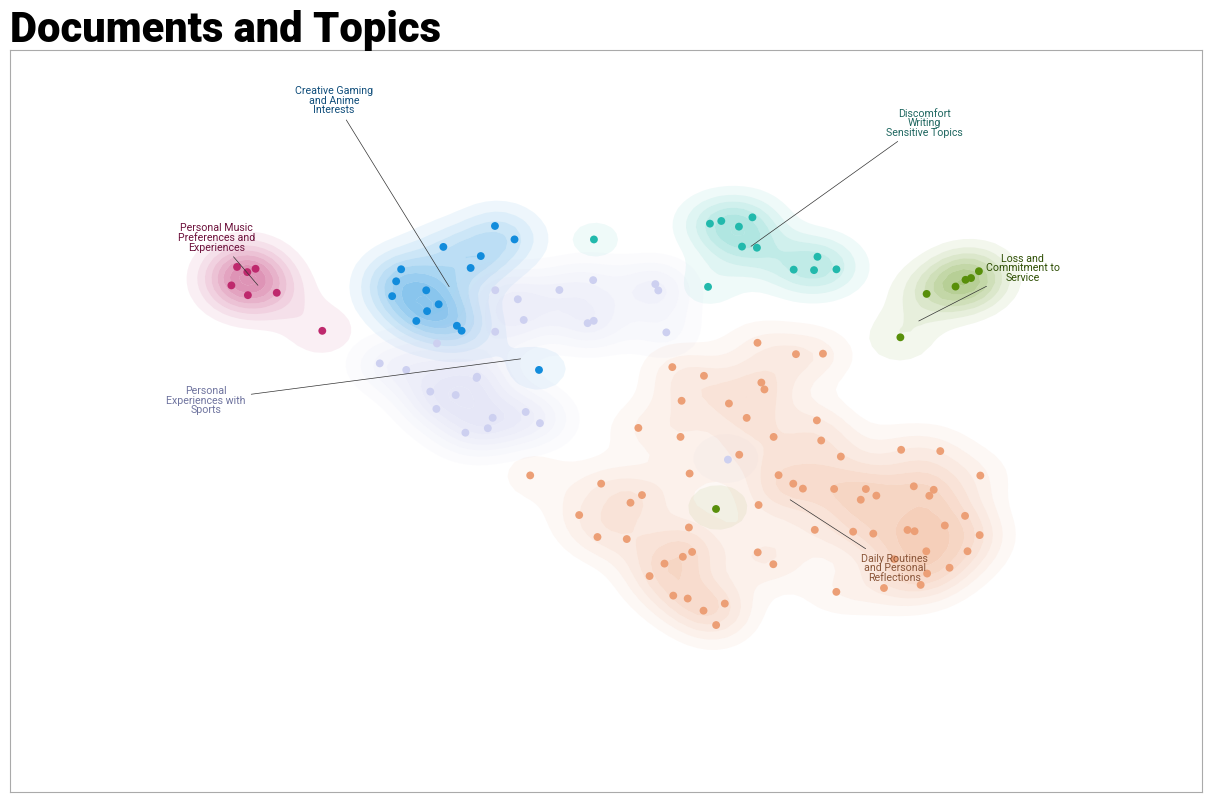

Translating topic words to English...

Translated Topics (Portuguese → English):
Topic 0: day, today, to do, go, why
Topic 1: sport, I like, to feel, why, day
Topic 2: games, history, to play, anime, I like
Topic 3: to write, detail, I feel comfortable, comfortable, I feel
Topic 4: music, to hear, taste, I like, quite
Topic 5: best friend, acceptance, cause, death, friend
DEBUG: Available topics for plotting: [0, 1, 2, 3, 4, 5]
DEBUG: Topic 0 -> Label: Daily Routines and Personal Reflections
DEBUG: Topic 1 -> Label: Personal Experiences with Sports
DEBUG: Topic 2 -> Label: Creative Gaming and Anime Interests
DEBUG: Topic 3 -> Label: Discomfort Writing Sensitive Topics
DEBUG: Topic 4 -> Label: Personal Music Preferences and Experiences
DEBUG: Topic 5 -> Label: Loss and Commitment to Service
🔧 Applying translated_barchart specific optimizations...
🖼️  Saved bertopic_translated_barchart_Male_noADHD as PNG: 20250815_011136_bertopic_translated_barchart_male_noadhd.png
📊 Saved bertopic_trans

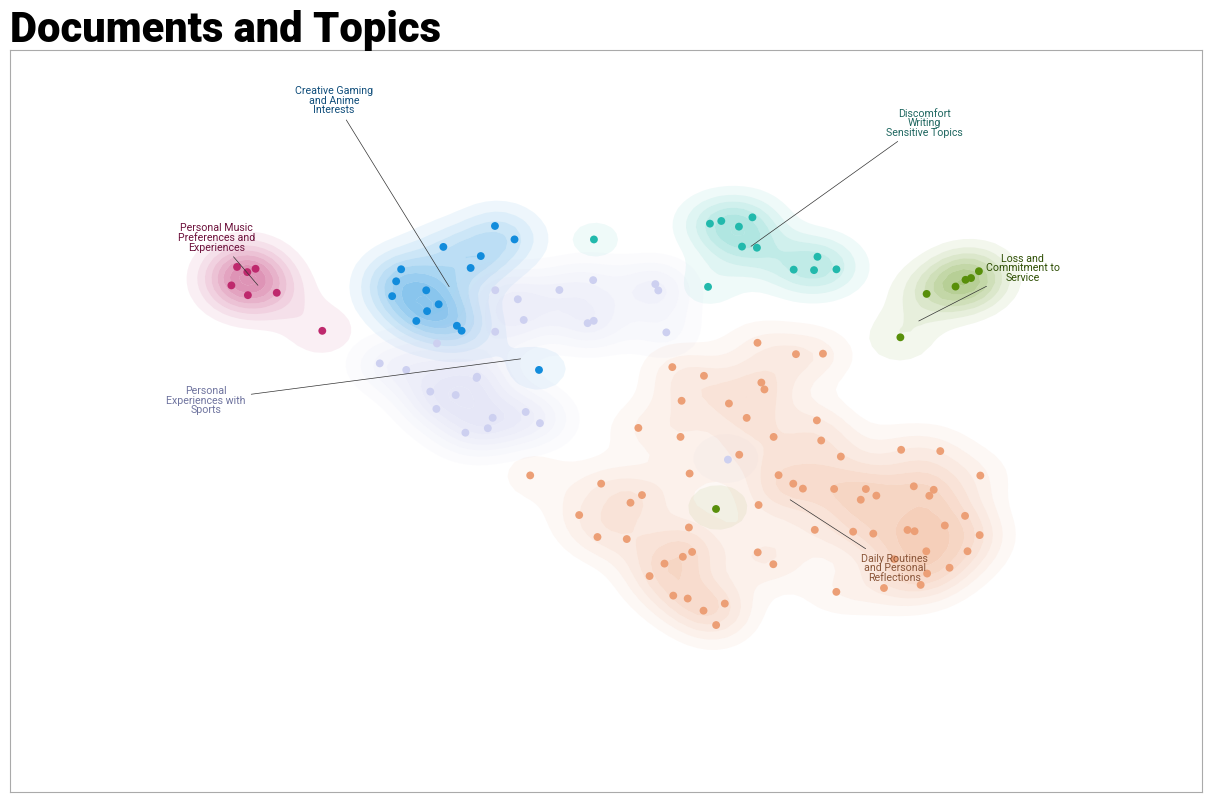

In [38]:
run_bertopic_viz(topic_model, df_group, output_folder, "Male_noADHD")

## Female

In [39]:
folder = next(f for f in folders if f.startswith("Female_2"))
print(folder)
df_group, topic_model, output_folder = preliminary_steps(folder)
check_hierarchy(topic_model, df_group, output_folder, "Female")

Female_20250814_235513_2
Running preliminary steps for folder: Female_20250814_235513_2
Female


100%|██████████| 9/9 [00:00<00:00, 497.74it/s]


🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_Female as PNG: 20250815_011140_bertopic_hierarchy_female.png
📊 Saved bertopic_hierarchy_Female as HTML: 20250815_011140_bertopic_hierarchy_female.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_20250814_235513_2
------------------------------------------------------------


🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female as PNG: 20250815_011141_bertopic_topics_female.png
📊 Saved bertopic_topics_Female as HTML: 20250815_011141_bertopic_topics_female.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Female'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_20250814_235513_2
------------------------------------------------------------


.
├─dia_porque_hoje_fazer_ainda
│    ├─trabalho_porque_dia_fazer_hoje
│    │    ├─■──ir_dia_porque_hoje_trabalho ── Topic: 7
│    │    └─■──trabalho_fazer_projeto_dormir_porque ── Topic: 6
│    └─ainda_dia_hoje_porque_anos
│         ├─■──pai_almoço_ainda_tarde_dia ── Topic: 4
│         └─■──lembro_memória_mim_anos_mãe ── Topic: 0
└─gosto_música_interesse_porque_pessoas
     ├─gosto_música_interesse_adoro_porque
     │    ├─gosto_música_interesse_ler_porque
     │    │    ├─■──música_ouvir_fazer_teatro_tocar ── Topic: 8
     │    │    └─gosto_interesse_ler_porque_forma
     │    │         ├─ler_interesse_gosto_forma_porque
     │    │         │    ├─■──gosto_cozinhar_adoro_focada_permite ── Topic: 3
     │    │         │    └─■──ler_interesse_forma_porque_músicas ── Topic: 1
     │    │         └─■──gosto_saúde_mental_interesse_alimentação ── Topic: 2
     │    └─■──conhecer_sentir_viajar_mundo_gosto ── Topic: 5
     └─■──phda_gostaria_pessoas_gostava_filho ── Topic: 9



In [40]:
topic_info = topic_model.get_topic_info()
display(topic_info)
topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)

Topic  Count                             Name  \
0      -1     73     -1_dia_animais_pessoas_fazer   
1       0     74        0_lembro_memória_mim_anos   
2       1     30     1_ler_interesse_forma_porque   
3       2     19   2_gosto_saúde_mental_interesse   
4       3     17    3_gosto_cozinhar_adoro_focada   
5       4     16         4_pai_almoço_ainda_tarde   
6       5     13   5_conhecer_sentir_viajar_mundo   
7       6     13  6_trabalho_fazer_projeto_dormir   
8       7     13             7_ir_dia_porque_hoje   
9       8     11      8_música_ouvir_fazer_teatro   
10      9      6  9_phda_gostaria_pessoas_gostava   

                               CustomName  \
0                           Outlier Topic   
1    Personal Growth and Social Belonging   
2         Personal Fandoms and Obsessions   
3        Personal Interests and Wellbeing   
4     Creative Relaxation Through Hobbies   
5      Daily Routines and Family Dynamics   
6     Experiencing Freedom Through Travel   
7      Work, Emotions, and Daily Routines   
8      Daily Life and Emotional Struggles   
9   Music and Performing Arts Experiences   
10    Neurodivergence Stigma and Advocacy   

                                       Representation  \
0   [dia, animais, pessoas, fazer, ver, vezes, dia...   
1   [lembro, memória, mim, anos, mãe, tudo, nunca,...   
2   [ler, interesse, forma, porque, músicas, gosto...   
3   [gosto, saúde, mental, interesse, alimentação,...   
4   [gosto, cozinhar, adoro, focada, permite, faze...   
5   [pai, almoço, ainda, tarde, dia, hoje, acordei...   
6   [conhecer, sentir, viajar, mundo, gosto, liber...   
7   [trabalho, fazer, projeto, dormir, porque, cas...   
8   [ir, dia, porque, hoje, trabalho, manhã, quero...   
9   [música, ouvir, fazer, teatro, tocar, tanto, c...   
10  [phda, gostaria, pessoas, gostava, filho, nenh...   

                                              KeyBERT  \
0   [fiquei, dificuldade, senti, sair, ir, mim, cé...   
1   [senti, ansiedade, comigo, altura, amigos, med...   
2   [the, imenso, ler, séries, histórias, fascina,...   
3   [adoro conhecer, interesses, interesses especi...   
4   [fazer, porque gosto, criatividade, criativa, ...   
5   [acordei tarde, hoje acordei, acordei, cansada...   
6   [viajar, adoro conhecer, viver, passear, senti...   
7   [acordei, faço, stress, fiz, tarefas, fazer, s...   
8   [ansiedade, hoje senti, stressada, sentia, fiq...   
9   [musical, música, tocar, faço, ouvir, tendo, f...   
10  [diagnosticado, diagnóstico, parte pessoas, so...   

                                           OpenAI  \
0   [Personal Challenges and Emotional Struggles]   
1          [Personal Growth and Social Belonging]   
2               [Personal Fandoms and Obsessions]   
3              [Personal Interests and Wellbeing]   
4           [Creative Relaxation Through Hobbies]   
5            [Daily Routines and Family Dynamics]   
6           [Experiencing Freedom Through Travel]   
7            [Work, Emotions, and Daily Routines]   
8            [Daily Life and Emotional Struggles]   
9         [Music and Performing Arts Experiences]   
10          [Neurodivergence Stigma and Advocacy]   

                                                  MMR  \
0   [ver, vezes, hoje, nunca, coisas, sinto, gosta...   
1   [memória, mim, mãe, nunca, ainda, melhor, hoje...   
2   [ler, gosto, história, interesse especial, per...   
3   [gosto, alimentação, física, aprender, coisas,...   
4   [cozinhar, fazer, cor, pontos, acalma, especia...   
5   [pai, almoço, tarde, hoje, acordei, horas, tra...   
6   [conhecer, viajar, liberdade, adoro, sol, sent...   
7   [fazer, dormir, tempo, hoje, feliz, deixar, co...   
8   [ir, hoje, semana, nervosa, sentia, passei, mé...   
9   [música, teatro, aprender, vida, coisas, fotog...   
10  [phda, tantos, lembrar, diferente, estudar, pr...   

                                                  POS  Representative_Docs  
0   [dia, animais, pessoas, vezes, dias, campo, ve...    

In [41]:
run_bertopic_evals(topic_model, df_group, output_folder)

Silhouette score calculated on 212 documents across 10 topics
Silhouette Score: 0.0149
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.3889
Individual Topic Coherences:
  Topic 0: -1.1131
  Topic 1: -1.4394
  Topic 2: -1.4110
  Topic 3: -1.7392
  Topic 4: -1.1125
  Topic 5: -1.3803
  Topic 6: -1.2445
  Topic 7: -1.5472
  Topic 8: -1.4379
  Topic 9: -1.4643
Coherence results saved to ../../outputs/bertopic_results/Female_20250814_235513_2/


Number of texts: 285
Number of topics: 285


Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...      3   
1    Gosto de ver séries porque relatam relações sa...      1   
2    Campos de ferias. Temos que criar o campo todo...     -1   
3    Taylor Swift, amo o seu liricismo e a maneira ...      2   
4    Historia da arte \nÉ só tão interessante. Para...      3   
..                                                 ...    ...   
280  Maiores dificuldades que sempre senti.. Concen...     -1   
281  O ponto em que sociedade se está a tornar,: eg...     -1   
282  Gostava que não dissessem : toda a gente tem p...      9   
283  Não sei explicar o que se anda a passar comigo...     -1   
284  Alguém me mande um milagre, I am going crazy, ...      7   

                                Name                           CustomName  \
0      3_gosto_cozinhar_adoro_focada  Creative Relaxation Through Hobbies   
1       1_ler_interesse_forma_porque      Personal Fandoms and Obsessions   
2       -1_dia_animais_pessoas_fazer                        Outlier Topic   
3     2_gosto_saúde_mental_interesse     Personal Interests and Wellbeing   
4      3_gosto_cozinhar_adoro_focada  Creative Relaxation Through Hobbies   
..                               ...                                  ...   
280     -1_dia_animais_pessoas_fazer                        Outlier Topic   
281     -1_dia_animais_pessoas_fazer                        Outlier Topic   
282  9_phda_gostaria_pessoas_gostava  Neurodivergence Stigma and Advocacy   
283     -1_dia_animais_pessoas_fazer                        Outlier Topic   
284             7_ir_dia_porque_hoje   Daily Life and Emotional Struggles   

                                        Representation  \
0    [gosto, cozinhar, adoro, focada, permite, faze...   
1    [ler, interesse, forma, porque, músicas, gosto...   
2    [dia, animais, pessoas, fazer, ver, vezes, dia...   
3    [gosto, saúde, mental, interesse, alimentação,...   
4    [gosto, cozinhar, adoro, focada, permite, faze...   
..                                                 ...   
280  [dia, animais, pessoas, fazer, ver, vezes, dia...   
281  [dia, animais, pessoas, fazer, ver, vezes, dia...   
282  [phda, gostaria, pessoas, gostava, filho, nenh...   
283  [dia, animais, pessoas, fazer, ver, vezes, dia...   
284  [ir, dia, porque, hoje, trabalho, manhã, quero...   

                                               KeyBERT  \
0    [fazer, porque gosto, criatividade, criativa, ...   
1    [the, imenso, ler, séries, histórias, fascina,...   
2    [fiquei, dificuldade, senti, sair, ir, mim, cé...   
3    [adoro conhecer, interesses, interesses especi...   
4    [fazer, porque gosto, criatividade, criativa, ...   
..                                                 ...   
280  [fiquei, dificuldade, senti, sair, ir, mim, cé...   
281  [fiquei, dificuldade, senti, sair, ir, mim, cé...   
282  [diagnosticado, diagnóstico, parte pessoas, so...   
283  [fiquei, dificuldade, senti, sair, ir, mim, cé...   
284  [ansiedade, hoje senti, stressada, sentia, fiq...   

                                            OpenAI  \
0            [Creative Relaxation Through Hobbies]   
1                [Personal Fandoms and Obsessions]   
2    [Personal Challenges and Emotional Struggles]   
3               [Personal Interests and Wellbeing]   
4            [Creative Relaxation Through Hobbies]   
..                                             ...   
280  [Personal Challenges and Emotional Struggles]   
281  [Personal Challenges and Emotional Struggles]   
282          [Neurodivergence Stigma and Advocacy]   
283  [Personal Challenges and Emotional Struggles]   
284           [Daily Life and Emotional Struggles]   

                                                   MMR  \
0    [cozinhar, fazer, cor, pontos, acalma, especia...   
1    [ler, gosto, história, interesse especial, per...   
2    [ver, vezes, hoje, nunca, coisas, sinto, gosta...   
3    [gosto, alimentação, física, aprender, coisas,...   
4    [c

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female as PNG: 20250815_011143_bertopic_heatmap_female.png
📊 Saved bertopic_heatmap_Female as HTML: 20250815_011143_bertopic_heatmap_female.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_20250814_235513_2
------------------------------------------------------------


4it [00:00, 107.95it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female as PNG: 20250815_011145_bertopic_topics_per_class_female.png
📊 Saved bertopic_topics_per_class_Female as HTML: 20250815_011145_bertopic_topics_per_class_female.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_20250814_235513_2
------------------------------------------------------------


🖼️  Saved bertopic_document_datamap_Female as PNG: 20250815_011148_bertopic_document_datamap_female.png
📊 Saved bertopic_document_datamap_Female as HTML: 20250815_011148_bertopic_document_datamap_female.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_20250814_235513_2
------------------------------------------------------------


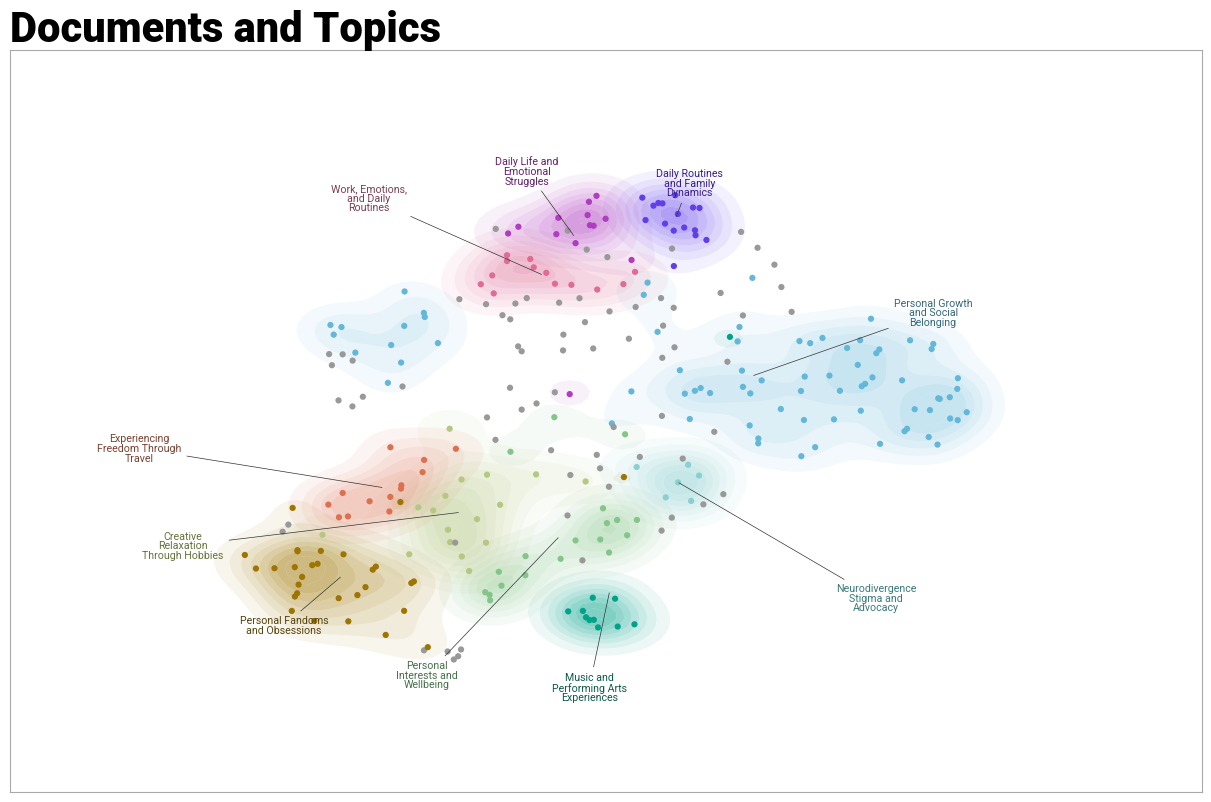

Translating topic words to English...

Translated Topics (Portuguese → English):
Topic 0: I remember, memory, me, years, mother
Topic 1: to read, interest, shape, why, songs
Topic 2: I like, health, mental, interest, food
Topic 3: I like, to cook, I adore, focused, allow
Topic 4: father, lunch, yet, afternoon, day
Topic 5: to know, to feel, travel, world, I like
Topic 6: work, to do, project, sleep, why
Topic 7: go, day, why, today, work
Topic 8: music, to hear, to do, theater, touch
Topic 9: adhd, I would like, people, liked, son
DEBUG: Available topics for plotting: [0, 1, 2, 3, 4, 5]
DEBUG: Topic 0 -> Label: Personal Growth and Social Belonging
DEBUG: Topic 1 -> Label: Personal Fandoms and Obsessions
DEBUG: Topic 2 -> Label: Personal Interests and Wellbeing
DEBUG: Topic 3 -> Label: Creative Relaxation Through Hobbies
DEBUG: Topic 4 -> Label: Daily Routines and Family Dynamics
DEBUG: Topic 5 -> Label: Experiencing Freedom Through Travel
🔧 Applying translated_barchart specific optimiz

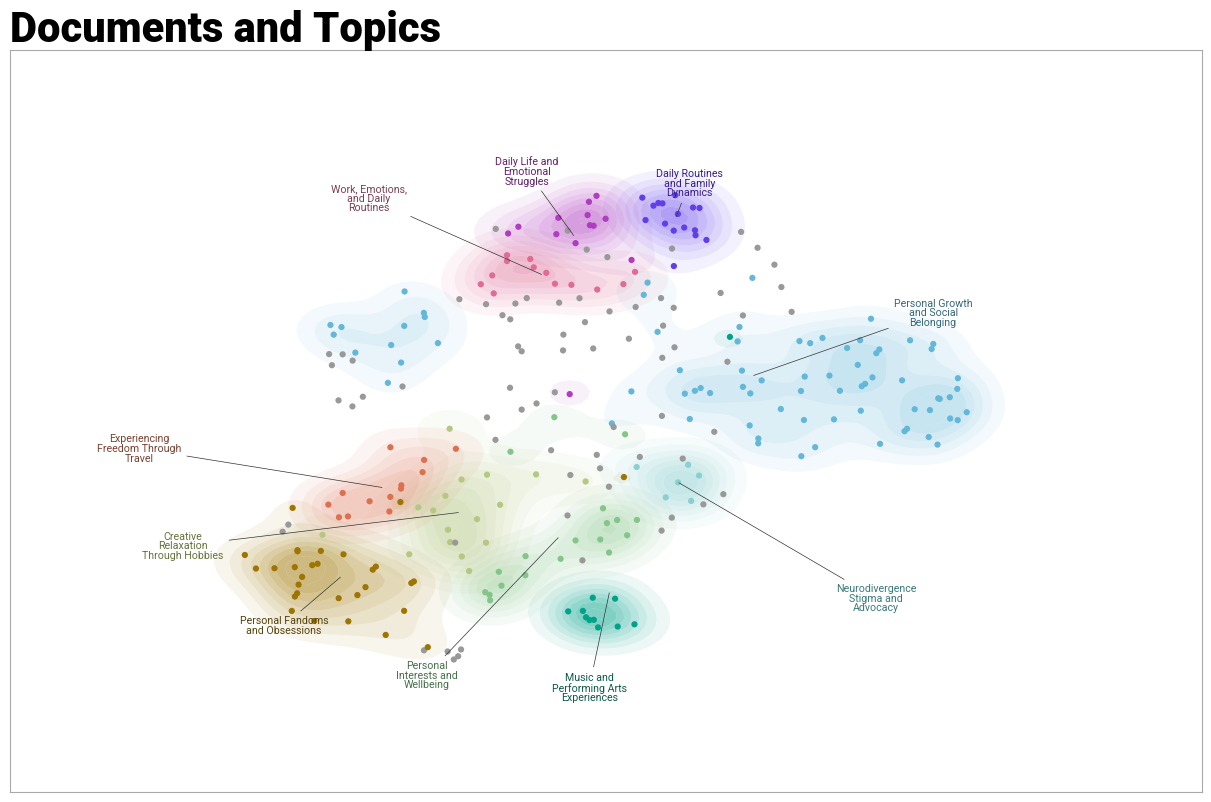

In [42]:
run_bertopic_viz(topic_model, df_group, output_folder, "Female")

## Male

In [43]:
folder = next(f for f in folders if f.startswith("Male_2"))
print(folder)
df_group, topic_model, output_folder = preliminary_steps(folder)
check_hierarchy(topic_model, df_group, output_folder, "Male")

Male_20250814_235513_2
Running preliminary steps for folder: Male_20250814_235513_2
Male


100%|██████████| 9/9 [00:00<00:00, 523.54it/s]


🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_Male as PNG: 20250815_011211_bertopic_hierarchy_male.png
📊 Saved bertopic_hierarchy_Male as HTML: 20250815_011211_bertopic_hierarchy_male.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Male'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_20250814_235513_2
------------------------------------------------------------


🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Male as PNG: 20250815_011212_bertopic_topics_male.png
📊 Saved bertopic_topics_Male as HTML: 20250815_011212_bertopic_topics_male.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Male'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_20250814_235513_2
------------------------------------------------------------


.
├─porque_dia_fazer_algo_hoje
│    ├─■──música_ouvir_gostos_gosto_bastante ── Topic: 6
│    └─dia_fazer_porque_hoje_algo
│         ├─fazer_dia_porque_hoje_ir
│         │    ├─gosto_desporto_jogar_desde_jogo
│         │    │    ├─■──jogos_desde_saber_jogar_gosto ── Topic: 2
│         │    │    └─■──gosto_desporto_sentir_tipo_vezes ── Topic: 3
│         │    └─hoje_dia_fazer_ir_porque
│         │         ├─■──dia_fazer_tarde_ir_hoje ── Topic: 0
│         │         └─■──anos_pai_memória_hoje_ainda ── Topic: 1
│         └─■──medicação_phda_começar_estado_medo ── Topic: 4
└─escrever_sinto confortável_detalhe_sinto_confortável
     ├─escrever_sinto confortável_detalhe_sinto_confortável
     │    ├─■──constante_capacidade_usar_outra_qualquer ── Topic: 8
     │    └─escrever_sinto confortável_detalhe_sinto_confortável
     │         ├─■──nada_saber_ainda_sinto_conjunto ── Topic: 9
     │         └─■──escrever_sinto confortável_detalhe_confortável_sinto ── Topic: 5
     └─■──14_causa_aceite__ 

In [44]:
topic_info = topic_model.get_topic_info()
display(topic_info)
topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)

Topic  Count                                              Name  \
0      -1     10    -1_história_interesse_interesse especial_parte   
1       0     51                              0_dia_fazer_tarde_ir   
2       1     24                           1_anos_pai_memória_hoje   
3       2     18                         2_jogos_desde_saber_jogar   
4       3     17                      3_gosto_desporto_sentir_tipo   
5       4      8                   4_medicação_phda_começar_estado   
6       5      8  5_escrever_sinto confortável_detalhe_confortável   
7       6      7                       6_música_ouvir_gostos_gosto   
8       7      7                                7_14_causa_aceite_   
9       8      6                 8_constante_capacidade_usar_outra   
10      9      6                          9_nada_saber_ainda_sinto   

                                    CustomName  \
0                                Outlier Topic   
1    Daily Routines and Productivity Struggles   
2                 Reflecting on Life Decisions   
3    Creative Technology and Lifelong Learning   
4         Personal Sports and Leisure Passions   
5          ADHD, Medication, and Mental Health   
6       Discomfort Discussing Sensitive Topics   
7   Personal Music Preferences and Experiences   
8       Firefighter Leadership Invitation 2014   
9                   Human Society and Behavior   
10                Uncertainty of Self-Identity   

                                       Representation  \
0   [história, interesse, interesse especial, part...   
1   [dia, fazer, tarde, ir, hoje, porque, tempo, t...   
2   [anos, pai, memória, hoje, ainda, antes, futeb...   
3   [jogos, desde, saber, jogar, gosto, mundo, jog...   
4   [gosto, desporto, sentir, tipo, vezes, jogar, ...   
5   [medicação, phda, começar, estado, medo, nível...   
6   [escrever, sinto confortável, detalhe, confort...   
7   [música, ouvir, gostos, gosto, bastante, prime...   
8                   [14, causa, aceite, , , , , , , ]   
9   [constante, capacidade, usar, outra, qualquer,...   
10  [nada, saber, ainda, sinto, conjunto, dia sint...   

                                              KeyBERT  \
0   [interesse especial, gostar tanto, emocional, ...   
1   [comecei, fiquei, faço, fiz, acabei, senti, te...   
2   [memória, momentos, sentimento, mim, emoções, ...   
3   [várias técnicas, gosto jogar, muitas, fazer, ...   
4   [gosto jogar, gosto fazer, gosto bastante, des...   
5   [saúde mental, stressar, mental, obsessiva, me...   
6   [escrever, discutir, situações, pessoal, sinto...   
7   [ouvir música, música, ouvir, sentir, sinto, e...   
8                                [, , , , , , , , , ]   
9   [mexer, fazer, usar, humanos, constante, socie...   
10  [sinto, dia sinto, memórias, lembrar, nada, pe...   

                                          OpenAI  \
0            [Personal Interests and Narratives]   
1    [Daily Routines and Productivity Struggles]   
2                 [Reflecting on Life Decisions]   
3    [Creative Technology and Lifelong Learning]   
4         [Personal Sports and Leisure Passions]   
5          [ADHD, Medication, and Mental Health]   
6       [Discomfort Discussing Sensitive Topics]   
7   [Personal Music Preferences and Experiences]   
8       [Firefighter Leadership Invitation 2014]   
9                   [Human Society and Behavior]   
10                [Uncertainty of Self-Identity]   

                                                  MMR  \
0   [história, interesse especial, anime, gostar t...   
1   [tarde, tempo, consegui, melhor, apesar, coisa...   
2   [pai, memória, antes, futebol, cabeça, situaçã...   
3   [jogos, gosto, fazer, própria, coisas, ideias,...   
4   [desporto, vezes, quero, gosto fazer, f1, rece...   
5   [medicação, phda, medo, tomar, imenso, felizme...   
6   [escrever, sinto confortável, sinto, histórias...   
7   [música, gostos, primeira, ouvir música, senti...   
8   [14, causa, aceite, , , , , , , , , , , , , , ... 

In [45]:
run_bertopic_evals(topic_model, df_group, output_folder)

Silhouette score calculated on 152 documents across 10 topics
Silhouette Score: 0.0699
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.1233
Individual Topic Coherences:
  Topic 0: -1.2315
  Topic 1: -1.2731
  Topic 2: -1.3135
  Topic 3: -1.7724
  Topic 4: -0.8020
  Topic 5: -1.3101
  Topic 6: -1.1394
  Topic 7: 0.0000
  Topic 8: -1.1760
  Topic 9: -1.2147
Coherence results saved to ../../outputs/bertopic_results/Male_20250814_235513_2/


Number of texts: 162
Number of topics: 162


Document  Topic  \
0    Senhor dos anéis pelo expansivo mundo, históri...     -1   
1    Jogos no geral, adoro aprender e perceber mecâ...      2   
2    Música e como certos sons e instrumentos me fa...      6   
3    Video jogos, independentemente do género, gost...      2   
4       Adivinhar os dias da semana com base numa data      0   
..                                                 ...    ...   
157  Existem primatas que usam utensílios básicos c...      8   
158  Quero dormir. Quero deitar-me numa cama e apag...      3   
159  Física quântica para mim é super interessante ...      2   
160  Outras características minhas que possam ser r...      4   
161  De momento, na minha cabeça, só rumino sobre o...      0   

                                               Name  \
0    -1_história_interesse_interesse especial_parte   
1                         2_jogos_desde_saber_jogar   
2                       6_música_ouvir_gostos_gosto   
3                         2_jogos_desde_saber_jogar   
4                              0_dia_fazer_tarde_ir   
..                                              ...   
157               8_constante_capacidade_usar_outra   
158                    3_gosto_desporto_sentir_tipo   
159                       2_jogos_desde_saber_jogar   
160                 4_medicação_phda_começar_estado   
161                            0_dia_fazer_tarde_ir   

                                     CustomName  \
0                                 Outlier Topic   
1     Creative Technology and Lifelong Learning   
2    Personal Music Preferences and Experiences   
3     Creative Technology and Lifelong Learning   
4     Daily Routines and Productivity Struggles   
..                                          ...   
157                  Human Society and Behavior   
158        Personal Sports and Leisure Passions   
159   Creative Technology and Lifelong Learning   
160         ADHD, Medication, and Mental Health   
161   Daily Routines and Productivity Struggles   

                                        Representation  \
0    [história, interesse, interesse especial, part...   
1    [jogos, desde, saber, jogar, gosto, mundo, jog...   
2    [música, ouvir, gostos, gosto, bastante, prime...   
3    [jogos, desde, saber, jogar, gosto, mundo, jog...   
4    [dia, fazer, tarde, ir, hoje, porque, tempo, t...   
..                                                 ...   
157  [constante, capacidade, usar, outra, qualquer,...   
158  [gosto, desporto, sentir, tipo, vezes, jogar, ...   
159  [jogos, desde, saber, jogar, gosto, mundo, jog...   
160  [medicação, phda, começar, estado, medo, nível...   
161  [dia, fazer, tarde, ir, hoje, porque, tempo, t...   

                                               KeyBERT  \
0    [interesse especial, gostar tanto, emocional, ...   
1    [várias técnicas, gosto jogar, muitas, fazer, ...   
2    [ouvir música, música, ouvir, sentir, sinto, e...   
3    [várias técnicas, gosto jogar, muitas, fazer, ...   
4    [comecei, fiquei, faço, fiz, acabei, senti, te...   
..                                                 ...   
157  [mexer, fazer, usar, humanos, constante, socie...   
158  [gosto jogar, gosto fazer, gosto bastante, des...   
159  [várias técnicas, gosto jogar, muitas, fazer, ...   
160  [saúde mental, stressar, mental, obsessiva, me...   
161  [comecei, fiquei, faço, fiz, acabei, senti, te...   

                                           OpenAI  \
0             [Personal Interests and Narratives]   
1     [Creative Technology and Lifelong Learning]   
2    [Personal Music Preferences and Experiences]   
3     [Creative Technology and Lifelong Learning]   
4     [Daily Routines and Productivity Struggles]   
..                                            ...   
157                  [Human Society and Behavior]   
158        [Personal Sports and Leisure Passions]   
159   [Creative Technology and Lifelong Learning]   
160         [ADHD, Medication, and Mental Health]   
161   [Daily R

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Male as PNG: 20250815_011214_bertopic_heatmap_male.png
📊 Saved bertopic_heatmap_Male as HTML: 20250815_011214_bertopic_heatmap_male.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Male'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_20250814_235513_2
------------------------------------------------------------


4it [00:00, 140.14it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Male as PNG: 20250815_011216_bertopic_topics_per_class_male.png
📊 Saved bertopic_topics_per_class_Male as HTML: 20250815_011216_bertopic_topics_per_class_male.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Male'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_20250814_235513_2
------------------------------------------------------------


🖼️  Saved bertopic_document_datamap_Male as PNG: 20250815_011219_bertopic_document_datamap_male.png
📊 Saved bertopic_document_datamap_Male as HTML: 20250815_011219_bertopic_document_datamap_male.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Male'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_20250814_235513_2
------------------------------------------------------------


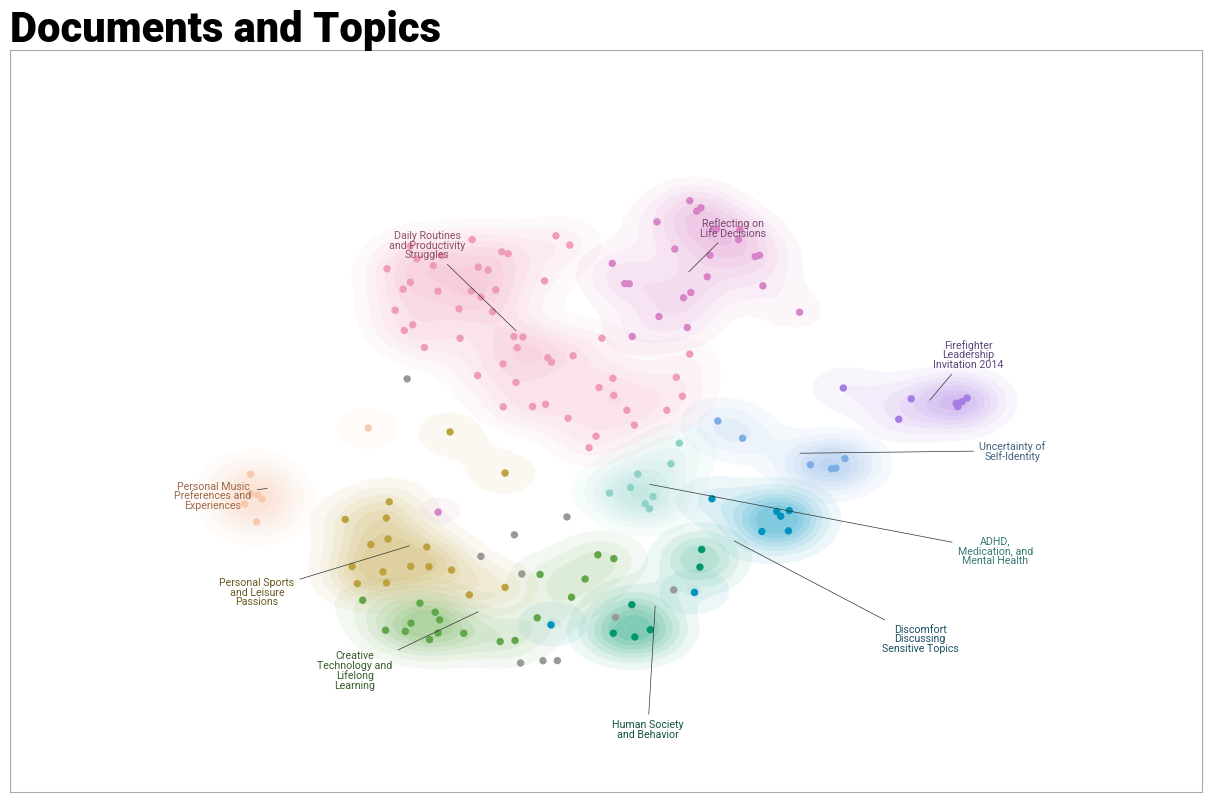

Translating topic words to English...

Translated Topics (Portuguese → English):
Topic 0: day, to do, afternoon, go, today
Topic 1: years, father, memory, today, yet
Topic 2: games, since, to know, to play, I like
Topic 3: I like, sport, to feel, type, times
Topic 4: medication, adhd, to start, state, fear
Topic 5: to write, I feel comfortable, detail, comfortable, I feel
Topic 6: music, to hear, taste, I like, quite
Topic 7: 14, cause, acceptance, , 
Topic 8: constant, capacity, to use, other, any
Topic 9: nothing, to know, yet, I feel, set
DEBUG: Available topics for plotting: [0, 1, 2, 3, 4, 5]
DEBUG: Topic 0 -> Label: Daily Routines and Productivity Struggles
DEBUG: Topic 1 -> Label: Reflecting on Life Decisions
DEBUG: Topic 2 -> Label: Creative Technology and Lifelong Learning
DEBUG: Topic 3 -> Label: Personal Sports and Leisure Passions
DEBUG: Topic 4 -> Label: ADHD, Medication, and Mental Health
DEBUG: Topic 5 -> Label: Discomfort Discussing Sensitive Topics
🔧 Applying translate

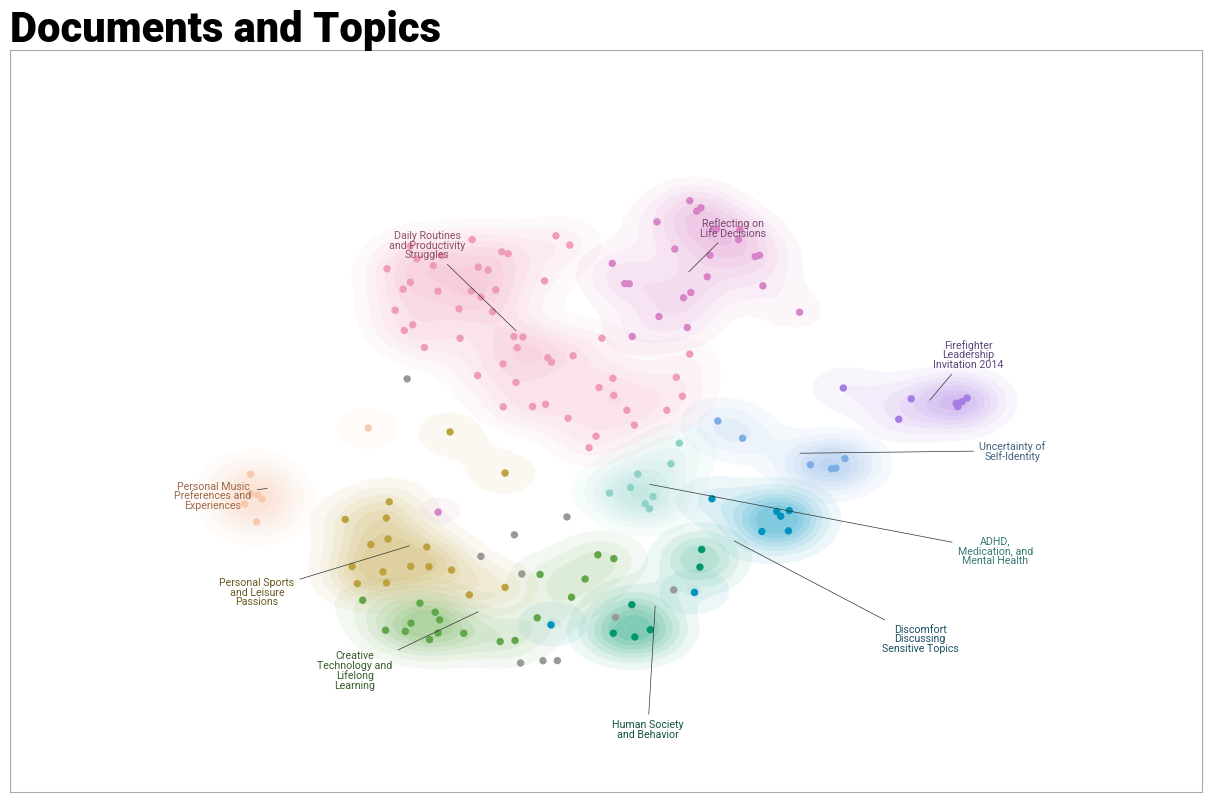

In [46]:
run_bertopic_viz(topic_model, df_group, output_folder, "Male")

# All

In [47]:
folder = next(f for f in folders if f.startswith("All_"))
print(folder)
df_group, topic_model, output_folder = preliminary_steps(folder)
check_hierarchy(topic_model, df_group, output_folder, "All")

All_20250814_235513_2
Running preliminary steps for folder: All_20250814_235513_2
All


100%|██████████| 27/27 [00:00<00:00, 561.94it/s]


🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_All as PNG: 20250815_011242_bertopic_hierarchy_all.png
📊 Saved bertopic_hierarchy_All as HTML: 20250815_011242_bertopic_hierarchy_all.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_All'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/All_20250814_235513_2
------------------------------------------------------------


🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_All as PNG: 20250815_011244_bertopic_topics_all.png
📊 Saved bertopic_topics_All as HTML: 20250815_011244_bertopic_topics_all.html
✅ Total saved: 2 file(s) for 'bertopic_topics_All'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/All_20250814_235513_2
------------------------------------------------------------


.
├─gosto_música_interesse_forma_adoro
│    ├─■──animais_gatos_animal_los_serem ── Topic: 22
│    └─gosto_música_interesse_forma_adoro
│         ├─gosto_desporto_jogos_adoro_jogar
│         │    ├─jogos_gosto_cozinhar_jogar_jogo
│         │    │    ├─■──cozinhar_gosto_adoro_utilizar_receitas ── Topic: 14
│         │    │    └─■──jogos_jogar_jogo_gosto_desde pequeno ── Topic: 6
│         │    └─desporto_gosto_sentir_adoro_acalma
│         │         ├─■──desporto_gosto_futebol_comunidade_ver ── Topic: 10
│         │         └─■──sentir_acalma_silêncio_permite_dá ── Topic: 1
│         └─música_gosto_interesse_ler_forma
│              ├─música_gosto_interesse_ler_história
│              │    ├─■──gosto_física_interesse_alimentação_saúde ── Topic: 8
│              │    └─música_ler_história_ouvir_interesse
│              │         ├─■──música_ouvir_teatro_músicas_ouvir música ── Topic: 3
│              │         └─ler_livros_história_forma_interesse
│              │              ├─■──ler_li

In [48]:
topic_info = topic_model.get_topic_info()
display(topic_info)
topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)

Topic  Count                                         Name  \
0      -1    106                      -1_vezes_fazer_algo_dia   
1       0     36                     0_tarde_pai_acordei_casa   
2       1     19             1_sentir_acalma_silêncio_permite   
3       2     19       2_phda_medicação_diagnóstico_depressão   
4       3     19                3_música_ouvir_teatro_músicas   
5       4     17                 4_anos_cabeça_futebol_altura   
6       5     16               5_eventos_algum_sinto_memórias   
7       6     16                     6_jogos_jogar_jogo_gosto   
8       7     14                         7_avó_morte_anos_avô   
9       8     14         8_gosto_física_interesse_alimentação   
10      9     14                      9_ler_livros_forma_saga   
11     10     14         10_desporto_gosto_futebol_comunidade   
12     11     14     11_história_personagem_anime_personagens   
13     12     13             12_trabalho_semana_projeto_tempo   
14     13     12           13_amigo_comigo_melhor amigo_grupo   
15     14     11             14_cozinhar_gosto_adoro_utilizar   
16     15     10              15_nada_pergunta_ocorre_nenhuma   
17     16      9       16_perceber_mental_justiça_pensamentos   
18     17      9           17_filme_historia_cinema_histórias   
19     18      8               18_trabalhar_ir_sentia_acordei   
20     19      8             19_notas_capaz_exame_capacidades   
21     20      8         20_escrever_sei bem_consigo_situação   
22     21      7        21_defender_bombeiros_2014_transmitir   
23     22      6                  22_animais_gatos_animal_los   
24     23      6      23_pessoas_mulheres_plataforma_eleições   
25     24      6  24_temas_detalhe_sinto confortável_escrever   
26     25      6            25_nervoso_bom_apresentação_super   
27     26      5             26_escolhas_mente_tomei_trabalho   
28     27      5                  27_avós_memória_ouro_lembro   

                                      CustomName  \
0                                  Outlier Topic   
1      Daily Routines and Personal Relationships   
2        Solitude and Mindful Leisure Activities   
3            Mental Health Diagnosis and Support   
4         Music Appreciation and Personal Impact   
5   Formative Childhood and Adolescence Memories   
6                Daily Emotional Self-Reflection   
7                 Gaming Passion and Development   
8                Family Loss and Personal Growth   
9     Diverse Personal Interests and Curiosities   
10             Personal Journeys Through Reading   
11                Enjoyment of Sports Activities   
12     Personal Connection to Fantasy Narratives   
13          Workload, Stress, and Prioritization   
14    Friendship Challenges and Emotional Impact   
15               Creative Expression and Cooking   
16                Difficulty Answering Questions   
17                  Mental Health Self-Awareness   
18               Impact of Film and Storytelling   
19   Work, Productivity, and Emotional Wellbeing   
20                Overcoming Academic Self-Doubt   
21               Daily struggles with motivation   
22  Firefighter Leadership and Knowledge Sharing   
23                        Animal Care and Ethics   
24           Gender, Politics, and Social Change   
25         Discomfort Discussing Personal Issues   
26     Overcoming Nerves in Public Presentations   
27              Academic Routine and Aspirations   
28          Childhood Memories with Grandparents   

                                       Representation  \
0   [vezes, fazer, algo, dia, tempo, ainda, sempre...   
1   [tarde, pai, acordei, casa, ir, almoço, hoje, ...   
2   [sentir, acalma, silêncio, permite, dá, adoro,...   
3   [phda, medicação, diagnóstico, depressão, psiq...   
4   [música, ouvir, teatro, músicas, ouvir música,...   
5   [anos, cabeça, futebol, altura, amigos, maria,...   
6   [eventos, algum, sinto, memórias, dia, aconteç...   
7   [jogos, jogar, jogo, gosto, desd

In [49]:
run_bertopic_evals(topic_model, df_group, output_folder)

Silhouette score calculated on 341 documents across 28 topics
Silhouette Score: 0.0441
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.4147
Individual Topic Coherences:
  Topic 0: -1.0998
  Topic 1: -1.6584
  Topic 2: -1.0964
  Topic 3: -1.2054
  Topic 4: -1.5278
  Topic 5: -1.8538
  Topic 6: -1.9011
  Topic 7: -1.5880
  Topic 8: -1.7488
  Topic 9: -1.5361
  Topic 10: -1.7946
  Topic 11: -0.8842
  Topic 12: -1.2016
  Topic 13: -1.0825
  Topic 14: -1.8229
  Topic 15: -1.7898
  Topic 16: -1.7498
  Topic 17: -1.2954
  Topic 18: -1.6675
  Topic 19: -0.7749
  Topic 20: -2.0403
  Topic 21: -0.1999
  Topic 22: -0.7671
  Topic 23: -1.4576
  Topic 24: -1.5387
  Topic 25: -1.3537
  Topic 26: -1.6419
  Topic 27: -1.3329
Coherence results saved to ../../outputs/bertopic_results/All_20250814_235513_2/


Number of texts: 447
Number of topics: 447


Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...     14   
1    Gosto de ver séries porque relatam relações sa...     17   
2    Campos de ferias. Temos que criar o campo todo...     -1   
3    Taylor Swift, amo o seu liricismo e a maneira ...     11   
4    Historia da arte \nÉ só tão interessante. Para...     11   
..                                                 ...    ...   
442  O ponto em que sociedade se está a tornar,: eg...     -1   
443  Gostava que não dissessem : toda a gente tem p...      2   
444  Não sei explicar o que se anda a passar comigo...     24   
445  De momento, na minha cabeça, só rumino sobre o...     19   
446  Alguém me mande um milagre, I am going crazy, ...     18   

                                            Name  \
0               14_cozinhar_gosto_adoro_utilizar   
1             17_filme_historia_cinema_histórias   
2                        -1_vezes_fazer_algo_dia   
3       11_história_personagem_anime_personagens   
4       11_história_personagem_anime_personagens   
..                                           ...   
442                      -1_vezes_fazer_algo_dia   
443       2_phda_medicação_diagnóstico_depressão   
444  24_temas_detalhe_sinto confortável_escrever   
445             19_notas_capaz_exame_capacidades   
446               18_trabalhar_ir_sentia_acordei   

                                      CustomName  \
0                Creative Expression and Cooking   
1                Impact of Film and Storytelling   
2                                  Outlier Topic   
3      Personal Connection to Fantasy Narratives   
4      Personal Connection to Fantasy Narratives   
..                                           ...   
442                                Outlier Topic   
443          Mental Health Diagnosis and Support   
444        Discomfort Discussing Personal Issues   
445               Overcoming Academic Self-Doubt   
446  Work, Productivity, and Emotional Wellbeing   

                                        Representation  \
0    [cozinhar, gosto, adoro, utilizar, receitas, c...   
1    [filme, historia, cinema, histórias, forma, im...   
2    [vezes, fazer, algo, dia, tempo, ainda, sempre...   
3    [história, personagem, anime, personagens, pol...   
4    [história, personagem, anime, personagens, pol...   
..                                                 ...   
442  [vezes, fazer, algo, dia, tempo, ainda, sempre...   
443  [phda, medicação, diagnóstico, depressão, psiq...   
444  [temas, detalhe, sinto confortável, escrever, ...   
445  [notas, capaz, exame, capacidades, professora,...   
446  [trabalhar, ir, sentia, acordei, tese, porque,...   

                                               KeyBERT  \
0    [liberdade criativa, criatividade, criativa, c...   
1    [ver séries, cinema, séries, filme, sonhos, si...   
2    [senti, fiz, faço, fazer, mim, comigo, memória...   
3    [anime, fantasia, principal, the, série, roman...   
4    [anime, fantasia, principal, the, série, roman...   
..                                                 ...   
442  [senti, fiz, faço, fazer, mim, comigo, memória...   
443  [psiquiatra, depressão, psicóloga, doença, med...   
444  [temas, pessoal, situações, falar, sinto confo...   
445  [stressar, tentar acabar, aulas, mim própria, ...   
446  [acordei, sentia, sentisse, resolvi, chorar sa...   

                                            OpenAI  \
0                [Creative Expression and Cooking]   
1                [Impact of Film and Storytelling]   
2                [Personal Daily Life Experiences]   
3      [Personal Connection to Fantasy Narratives]   
4      [Personal Connection to Fantasy Narratives]   
..                                             ...   
442              [Personal Daily Life Experiences]   
443          [Mental Health Diagnosis and Support]   
444        [Discomfort Discussing Personal Issues]   
445               [Overcoming Academic Self-Doubt]   
446  [Work, Productivity, a

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_All as PNG: 20250815_011246_bertopic_heatmap_all.png
📊 Saved bertopic_heatmap_All as HTML: 20250815_011246_bertopic_heatmap_all.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_All'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/All_20250814_235513_2
------------------------------------------------------------


4it [00:00, 76.64it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_All as PNG: 20250815_011248_bertopic_topics_per_class_all.png
📊 Saved bertopic_topics_per_class_All as HTML: 20250815_011248_bertopic_topics_per_class_all.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_All'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/All_20250814_235513_2
------------------------------------------------------------


🖼️  Saved bertopic_document_datamap_All as PNG: 20250815_011254_bertopic_document_datamap_all.png
📊 Saved bertopic_document_datamap_All as HTML: 20250815_011254_bertopic_document_datamap_all.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_All'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/All_20250814_235513_2
------------------------------------------------------------


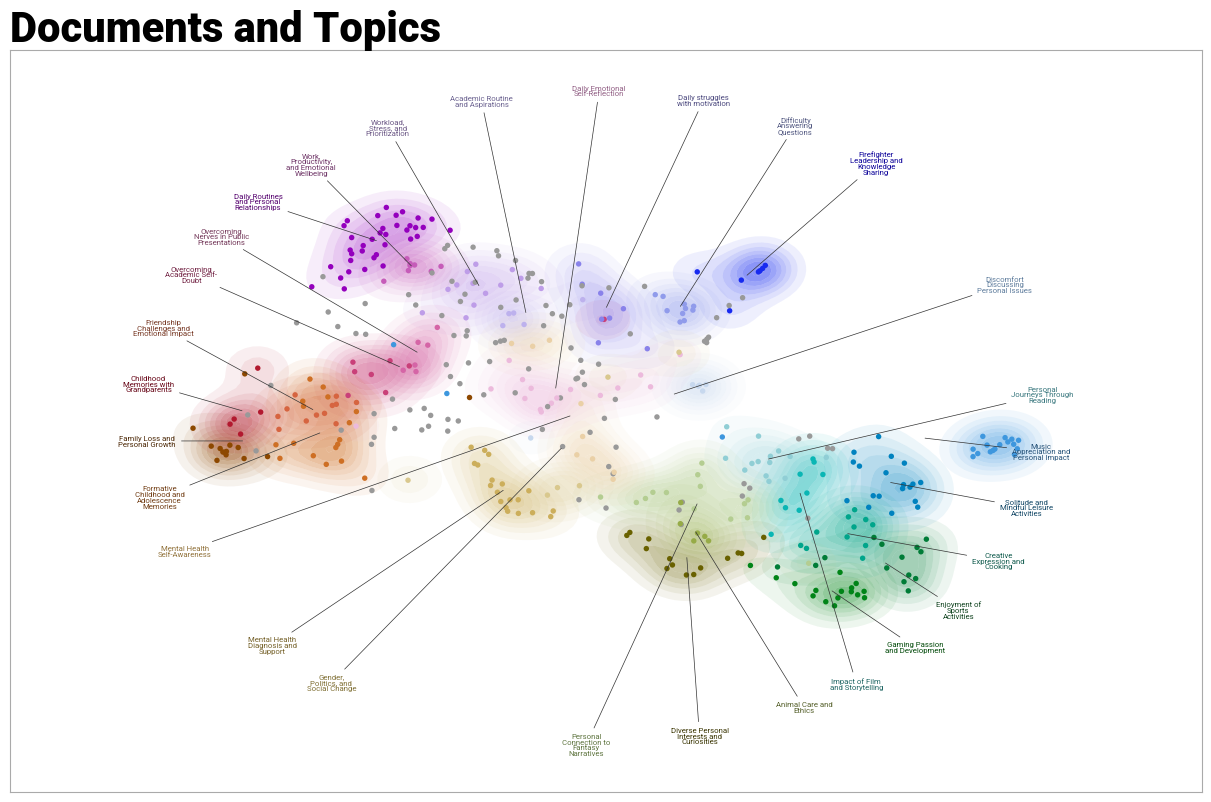

Translating topic words to English...

Translated Topics (Portuguese → English):
Topic 0: afternoon, father, I woke up, home, go
Topic 1: to feel, calm, silence, allow, from the
Topic 2: adhd, medication, diagnosis, depression, psychiatrist
Topic 3: music, to hear, theater, songs, listen
Topic 4: years, head, soccer, height, friends
Topic 5: events, some, I feel, memories, day
Topic 6: games, to play, game, I like, Since I was little
Topic 7: grandmother, death, years, grandmother, love
Topic 8: I like, physical, interest, food, health
Topic 9: to read, books, shape, saga, I like
Topic 10: sport, I like, soccer, community, see
Topic 11: history, character, anime, characters, policy
Topic 12: work, week, project, time, tomorrow
Topic 13: friend, with me, best friend, group, he spoke
Topic 14: to cook, I like, I adore, use, revenues
Topic 15: nothing, question, occur, none, objective
Topic 16: to perceive, mental, justice, thoughts, mental health
Topic 17: film, history, cinema, stories,

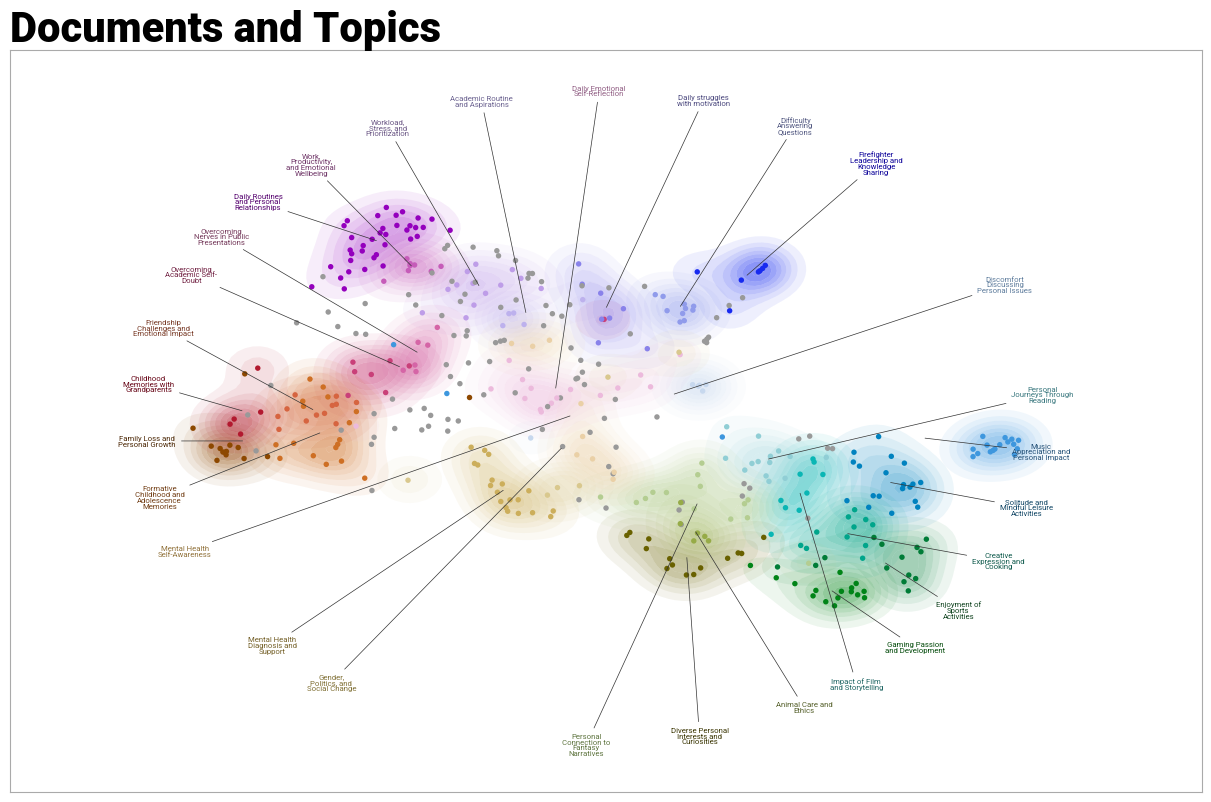

In [50]:
run_bertopic_viz(topic_model, df_group, output_folder, "All")